In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
supplejade_rt_iot2022real_time_internet_of_things_path = kagglehub.dataset_download('supplejade/rt-iot2022real-time-internet-of-things')

print('Data source import complete.')


100%|██████████| 3.64M/3.64M [00:00<00:00, 5.45MB/s]

Extracting files...


Data source import complete.


In [2]:
print(supplejade_rt_iot2022real_time_internet_of_things_path)

/root/.cache/kagglehub/datasets/supplejade/rt-iot2022real-time-internet-of-things/versions/3


In [3]:
!pip install "umap-learn==0.5.7"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: umap-learn
    Found existing installation: umap-learn 0.5.9.post2
    Uninstalling umap-learn-0.5.9.post2:
      Successfully uninstalled umap-learn-0.5.9.post2


In [4]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 19.2 MB/s eta 0:00:00


In [5]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 23.1 MB/s eta 0:00:00


# Libraries

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import shap
import optuna

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score,precision_score, recall_score, confusion_matrix,classification_report, ConfusionMatrixDisplay,accuracy_score
from sklearn.neighbors import LocalOutlierFactor

from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

import umap
from mpl_toolkits.mplot3d import Axes3D

import warnings

import time
from tqdm import tqdm

from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings('ignore')

# Data Loading

In [7]:
df = pd.read_csv('/root/.cache/kagglehub/datasets/supplejade/rt-iot2022real-time-internet-of-things/versions/3/RT_IOT2022.csv',  header=0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123117 entries, 0 to 123116
Data columns (total 85 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   no                        123117 non-null  int64  
 1   id.orig_p                 123117 non-null  int64  
 2   id.resp_p                 123117 non-null  int64  
 3   proto                     123117 non-null  object 
 4   service                   123117 non-null  object 
 5   flow_duration             123117 non-null  float64
 6   fwd_pkts_tot              123117 non-null  int64  
 7   bwd_pkts_tot              123117 non-null  int64  
 8   fwd_data_pkts_tot         123117 non-null  int64  
 9   bwd_data_pkts_tot         123117 non-null  int64  
 10  fwd_pkts_per_sec          123117 non-null  float64
 11  bwd_pkts_per_sec          123117 non-null  float64
 12  flow_pkts_per_sec         123117 non-null  float64
 13  down_up_ratio             123117 non-null  f

In [9]:
df = df.drop("no", axis=1)

In [10]:
df['Attack_type'] = df['Attack_type'].replace(['MQTT_Publish', 'Thing_Speak', 'Wipro_bulb'],'Normal')

In [11]:
le = LabelEncoder()
df["Attack_type"] = le.fit_transform(df["Attack_type"])

In [12]:
df = pd.get_dummies(df, columns=['service'], prefix='service')

In [13]:
df = df.drop("service_-", axis=1)

In [14]:
df = pd.get_dummies(df, columns=['proto'], prefix='proto')

In [15]:
def classwise_lof_auto(df, class_column='Attack_type', min_samples_for_lof=1000, n_neighbors=20, contamination=0.05):
    class_counts = df[class_column].value_counts()
    target_classes = class_counts[class_counts >= min_samples_for_lof].index.tolist()

    df_result = pd.DataFrame()

    for cls in df[class_column].unique():
        df_class = df[df[class_column] == cls]

        if cls in target_classes:
            numeric_cols = df_class.select_dtypes(include='number').columns
            df_numeric = df_class[numeric_cols].dropna()

            if len(df_numeric) >= n_neighbors:
                lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
                y_pred = lof.fit_predict(df_numeric)
                df_class = df_class.copy()
                df_class['LOF_outlier'] = 1
                df_class.loc[df_numeric.index, 'LOF_outlier'] = y_pred
            else:
                df_class['LOF_outlier'] = 1
        else:
            df_class['LOF_outlier'] = 1

        df_result = pd.concat([df_result, df_class])

    return df_result

In [16]:
lof_class_indices = df['Attack_type'].value_counts()[df['Attack_type'].value_counts() >= 1000].index.tolist()
lof_classes = le.inverse_transform(lof_class_indices)
print("LOF uygulanacak sınıflar:", list(lof_classes))

LOF uygulanacak sınıflar: ['DOS_SYN_Hping', 'Normal', 'ARP_poisioning', 'NMAP_UDP_SCAN', 'NMAP_XMAS_TREE_SCAN', 'NMAP_OS_DETECTION', 'NMAP_TCP_scan']


In [17]:
df_lof = classwise_lof_auto(df, class_column='Attack_type', min_samples_for_lof=1000)

In [18]:
df_clean = df_lof[df_lof['LOF_outlier'] == 1].drop(columns=['LOF_outlier'])

In [19]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type.name == 'category':
            continue

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [20]:
df = reduce_mem_usage(df_clean)

Memory usage of dataframe is 75.42 MB
Memory usage after optimization is: 30.35 MB
Decreased by 59.8%


# Subset

In [21]:
k=5000
label_column = 'Attack_type'

## K-Means

In [22]:
reduced_samples = []

for class_label in df[label_column].unique():
    class_df = df[df[label_column] == class_label]
    X_class = class_df.drop(columns=[label_column]).values
    n_samples = X_class.shape[0]

    if n_samples > k:
        reducer = umap.UMAP(n_components=3, random_state=42)
        X_umap = reducer.fit_transform(X_class)

        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_umap)

        _, indices = pairwise_distances_argmin_min(kmeans.cluster_centers_, X_umap)

        selected_samples = class_df.iloc[indices]
        reduced_samples.append(selected_samples)

    else:
        reduced_samples.append(class_df)

reduced_df = pd.concat(reduced_samples, ignore_index=True)

In [23]:
reduced_df['Attack_type'].value_counts()

,count
Attack_type,
9,5000
0,5000
2,5000
7,2460
8,1909
5,1900
6,951
1,534
3,37


# Test-Train Split

In [24]:
X = reduced_df.drop('Attack_type',axis=1)
y = reduced_df['Attack_type']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
print(f"\nX_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train distribution:\n{y_train.value_counts(normalize=True)}")
print(f"y_test distribution:\n{y_test.value_counts(normalize=True)}")


X_train shape: (18255, 93), X_test shape: (4564, 93)
y_train distribution:
Attack_type
0   0.220
2   0.220
9   0.219
7   0.107
8   0.084
5   0.082
6   0.042
1   0.023
3   0.002
4   0.001
Name: proportion, dtype: float64
y_test distribution:
Attack_type
9   0.221
2   0.217
0   0.215
7   0.110
5   0.087
8   0.083
6   0.041
1   0.024
3   0.002
4   0.001
Name: proportion, dtype: float64


# Catboost

In [27]:
def objective(trial):
    params = {
        'loss_function': 'MultiClass',
        'eval_metric': 'TotalF1',
        'task_type': 'GPU',
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-8, 10.0),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
        'verbose': 0,
        'random_seed': 42,
        'od_type': 'Iter',
        'od_wait': 50
    }

    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []

    for train_idx, valid_idx in kfold.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        cat_model = CatBoostClassifier(**params)

        cat_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=0)

        preds = cat_model.predict(X_valid)
        f1 = f1_score(y_valid, preds, average='weighted')
        f1_scores.append(f1)

    return np.mean(f1_scores)

In [28]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2025-12-14 16:49:21,849] A new study created in memory with name: no-name-3e026e03-a0eb-43d5-9fcf-8565709f5fed
[I 2025-12-14 16:49:37,050] Trial 0 finished with value: 0.9987189821695068 and parameters: {'iterations': 439, 'depth': 8, 'learning_rate': 0.03226339791444776, 'l2_leaf_reg': 3.3528618855850207, 'random_strength': 6.776351832280911, 'bagging_temperature': 0.08264260163059256, 'border_count': 39, 'min_data_in_leaf': 134}. Best is trial 0 with value: 0.9987189821695068.
[I 2025-12-14 16:49:52,627] Trial 1 finished with value: 0.999090968104053 and parameters: {'iterations': 280, 'depth': 9, 'learning_rate': 0.0015155054313581628, 'l2_leaf_reg': 6.74058003170056, 'random_strength': 5.698932226408467, 'bagging_temperature': 0.9159496557630841, 'border_count': 120, 'min_data_in_leaf': 39}. Best is trial 1 with value: 0.999090968104053.
[I 2025-12-14 16:50:05,507] Trial 2 finished with value: 0.9235362621809273 and parameters: {'iterations': 409, 'depth': 4, 'learning_rate': 0.

In [29]:
print("En iyi f1_weighted:", study.best_value)
print("En iyi parametreler:")
for key, val in study.best_trial.params.items():
    print(f"  {key}: {val}")

En iyi f1_weighted: 0.9994660244876424
En iyi parametreler:
  iterations: 968
  depth: 7
  learning_rate: 0.2961695375919912
  l2_leaf_reg: 0.15698148669087508
  random_strength: 0.36710955430493186
  bagging_temperature: 0.3323151306086932
  border_count: 56
  min_data_in_leaf: 211


In [30]:
best_cat_params = study.best_trial.params

In [31]:
best_cat_params

{'iterations': 968,
 'depth': 7,
 'learning_rate': 0.2961695375919912,
 'l2_leaf_reg': 0.15698148669087508,
 'random_strength': 0.36710955430493186,
 'bagging_temperature': 0.3323151306086932,
 'border_count': 56,
 'min_data_in_leaf': 211}

In [32]:
best_cat_params = {'iterations': 908,
 'depth': 9,
 'learning_rate': 0.17983976578485017,
 'l2_leaf_reg': 1.0428965968031374,
 'random_strength': 0.37700383798510945,
 'bagging_temperature': 0.10137277522349042,
 'border_count': 236,
 'min_data_in_leaf': 246}


Starting cross-validation with progress tracking...



Folds: 100%|██████████| 5/5 [01:30<00:00, 18.03s/it]



Cross-validation completed in 90.17 seconds.

Mean F1 Score: 0.9995
Mean Accuracy: 0.9995
Mean Precision: 0.9995
Mean Recall: 0.9995

Classification Report (All Folds Combined):

              precision    recall  f1-score   support

           0     0.9998    1.0000    0.9999      5000
           1     0.9944    0.9981    0.9963       534
           2     1.0000    1.0000    1.0000      5000
           3     0.9706    0.8919    0.9296        37
           4     0.8889    0.8571    0.8727        28
           5     1.0000    1.0000    1.0000      1900
           6     1.0000    1.0000    1.0000       951
           7     1.0000    0.9996    0.9998      2460
           8     0.9979    0.9990    0.9984      1909
           9     1.0000    1.0000    1.0000      5000

    accuracy                         0.9995     22819
   macro avg     0.9852    0.9746    0.9797     22819
weighted avg     0.9995    0.9995    0.9995     22819



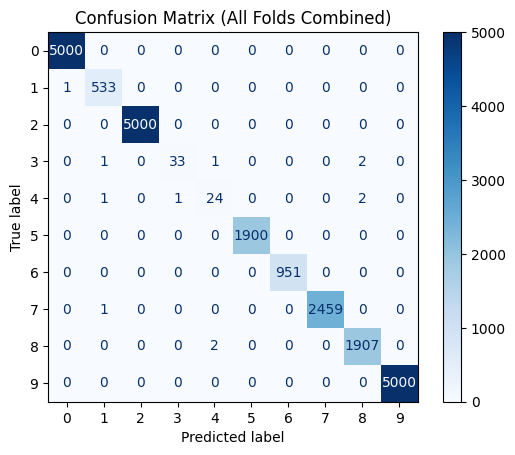

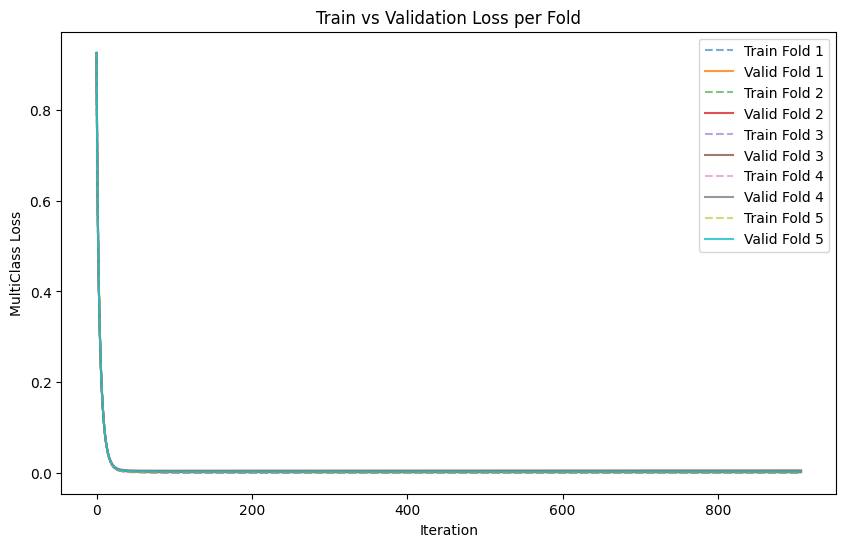

In [33]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

f1_scores = []
precision_scores = []
recall_scores = []
accuracy_scores = []


train_losses = []
valid_losses = []

all_y_valid = []
all_preds = []

start_time = time.time()

print("\nStarting cross-validation with progress tracking...\n")

for fold_idx, (train_idx, valid_idx) in enumerate(tqdm(kfold.split(X, y), total=kfold.get_n_splits(), desc='Folds'), 1):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    cat_model = CatBoostClassifier(
        **best_cat_params,
        task_type='GPU',
        eval_metric='MultiClass',
        verbose=100,
        random_seed=42,
    )

    cat_model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        verbose=False,
        use_best_model=True
    )

    preds = cat_model.predict(X_valid)

    all_y_valid.extend(y_valid)
    all_preds.extend(preds)

    f1 = f1_score(y_valid, preds, average='weighted')
    precision = precision_score(y_valid, preds, average='weighted', zero_division=0)
    recall = recall_score(y_valid, preds, average='weighted')
    accuracy = accuracy_score(y_valid, preds)

    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)
    accuracy_scores.append(accuracy)

    evals_result = cat_model.get_evals_result()
    train_loss = evals_result['learn']['MultiClass']
    valid_loss = evals_result['validation']['MultiClass']

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

total_time = time.time() - start_time

print(f"\nCross-validation completed in {total_time:.2f} seconds.\n")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")
print(f"Mean Accuracy: {np.mean(accuracy_scores):.4f}")
print(f"Mean Precision: {np.mean(precision_scores):.4f}")
print(f"Mean Recall: {np.mean(recall_scores):.4f}")

print("\nClassification Report (All Folds Combined):\n")
print(classification_report(all_y_valid, all_preds, digits=4))

cm = confusion_matrix(all_y_valid, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (All Folds Combined)")
plt.show()

plt.figure(figsize=(10, 6))
for i in range(len(train_losses)):
    plt.plot(train_losses[i], label=f'Train Fold {i+1}', linestyle='--', alpha=0.6)
    plt.plot(valid_losses[i], label=f'Valid Fold {i+1}', alpha=0.8)
plt.xlabel('Iteration')
plt.ylabel('MultiClass Loss')
plt.title('Train vs Validation Loss per Fold')
plt.legend()
plt.show()

In [34]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_valid)

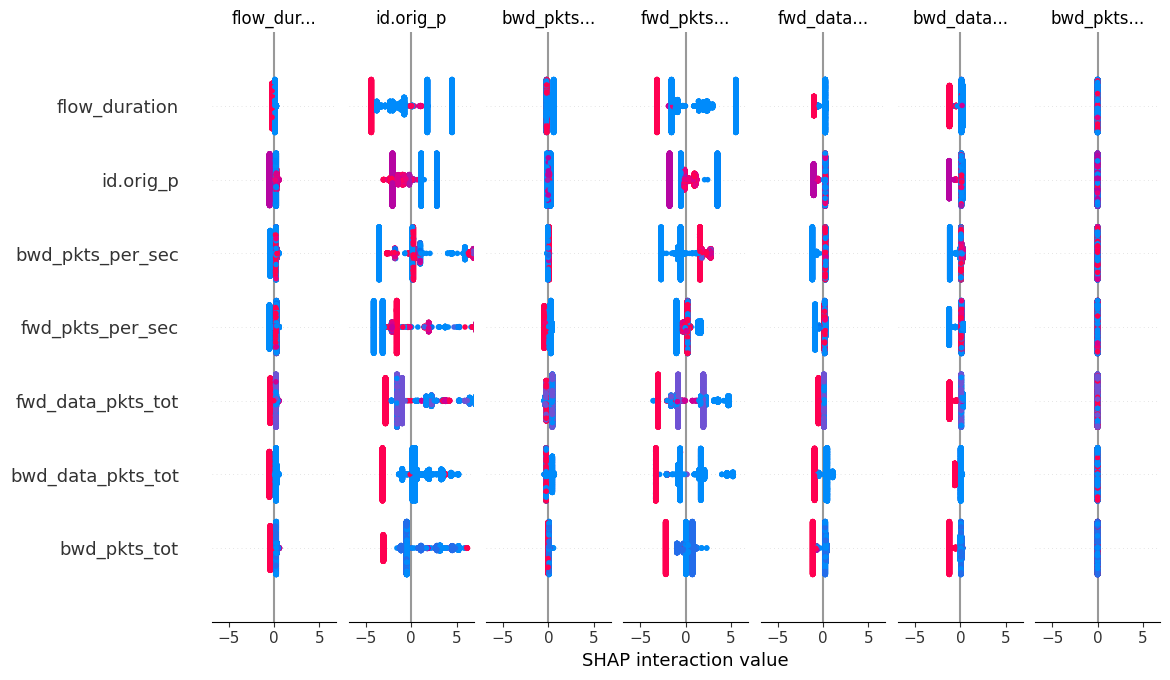

In [35]:
feature_names = X.columns

shap.summary_plot(shap_values, X_valid, feature_names=feature_names)

In [40]:
shap_matrix = np.stack(shap_values)

In [48]:
mean_shap = np.mean(
    np.abs(shap_matrix),
    axis=(0, 1)
)

# ----------------------------------------
# TOP-N FEATURE SELECTION
# ----------------------------------------

top_n = 48
top_features_idx = np.argsort(mean_shap)[::-1][:top_n]
top_feature_names = X_valid.columns[top_features_idx]

print(f"Selected top {top_n} features by SHAP:")
print(top_feature_names.tolist())

# Seçilmiş feature set
X_selected = X_valid[top_feature_names]

Selected top 48 features by SHAP:
['fwd_pkts_per_sec', 'flow_duration', 'id.resp_p', 'bwd_data_pkts_tot', 'fwd_pkts_tot', 'bwd_pkts_tot', 'bwd_pkts_per_sec', 'id.orig_p', 'fwd_data_pkts_tot', 'flow_pkts_per_sec']


In [ ]:
shap.summary_plot(
    shap_values,
    X_valid,
    feature_names=X_valid.columns,
    show=True
)


Starting cross-validation on SHAP-selected features (CORRECT)...



Folds: 100%|██████████| 5/5 [03:07<00:00, 37.48s/it]



SHAP-based CV completed in 187.38 seconds

Mean F1 Score:        0.99897
Mean Precision Score: 0.99903
Mean Recall Score:    0.99899

Classification Report (All Folds Combined):

              precision    recall  f1-score   support

           0     0.9994    1.0000    0.9997      5000
           1     0.9870    0.9963    0.9916       534
           2     1.0000    1.0000    1.0000      5000
           3     0.9062    0.7838    0.8406        37
           4     0.8571    0.8571    0.8571        28
           5     0.9989    1.0000    0.9995      1900
           6     1.0000    0.9958    0.9979       951
           7     0.9996    0.9988    0.9992      2460
           8     0.9984    0.9990    0.9987      1909
           9     1.0000    1.0000    1.0000      5000

    accuracy                         0.9990     22819
   macro avg     0.9747    0.9631    0.9684     22819
weighted avg     0.9990    0.9990    0.9990     22819



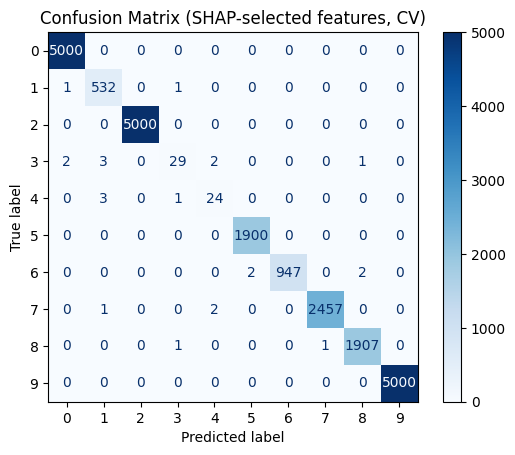

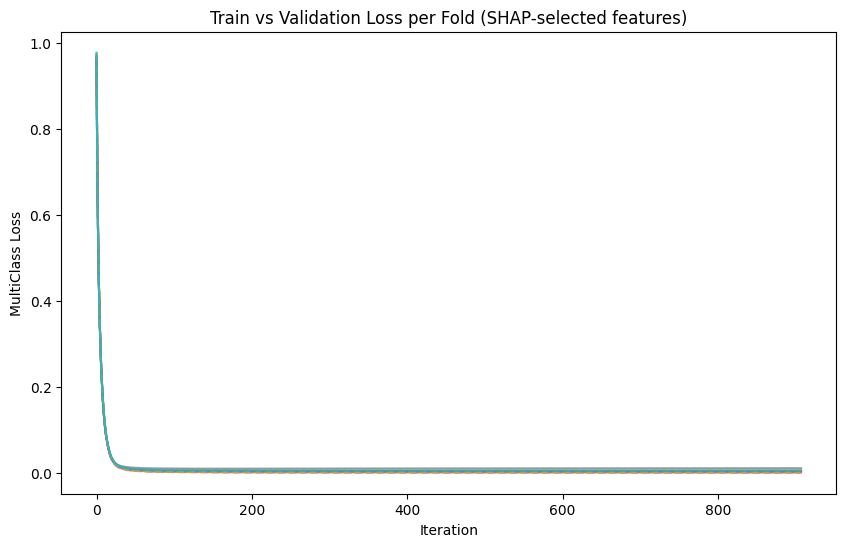

In [69]:
from sklearn.metrics import (
    f1_score, precision_score, recall_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

f1_scores = []
precision_scores = []
recall_scores = []

train_losses = []
valid_losses = []

all_y_valid = []
all_preds = []

start_time = time.time()

print("\nStarting cross-validation on SHAP-selected features (CORRECT)...\n")

for fold_idx, (train_idx, valid_idx) in enumerate(
        tqdm(kfold.split(X, y), total=kfold.get_n_splits(), desc='Folds'), 1):

    # ----------------------------------------
    # SPLIT (ORIGINAL DATA)
    # ----------------------------------------
    X_train_full, X_valid_full = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # ----------------------------------------
    # TRAIN MODEL (FULL FEATURES)
    # ----------------------------------------
    cat_model = CatBoostClassifier(
        **best_cat_params,
        task_type='GPU',
        eval_metric='MultiClass',
        verbose=False,
        random_seed=42
    )

    cat_model.fit(
        X_train_full, y_train,
        eval_set=(X_valid_full, y_valid),
        use_best_model=True,
        verbose=False
    )

    # ----------------------------------------
    # SHAP FEATURE SELECTION (TRAIN ONLY)
    # ----------------------------------------
    explainer = shap.TreeExplainer(cat_model)
    shap_values = explainer.shap_values(X_train_full)

    shap_matrix = np.stack(shap_values)  # (n_classes, n_samples, n_features)

    mean_shap = np.mean(
        np.abs(shap_matrix),
        axis=(0, 1)
    )

    top_n = 48
    top_features_idx = np.argsort(mean_shap)[::-1][:top_n]
    selected_features = X.columns[top_features_idx]

    # ----------------------------------------
    # REDUCE TRAIN & VALID SET
    # ----------------------------------------
    X_train = X_train_full[selected_features]
    X_valid = X_valid_full[selected_features]

    # ----------------------------------------
    # RETRAIN MODEL WITH SELECTED FEATURES
    # ----------------------------------------
    fs_model = CatBoostClassifier(
        **best_cat_params,
        task_type='GPU',
        eval_metric='MultiClass',
        verbose=False,
        random_seed=42
    )

    fs_model.fit(
        X_train, y_train,
        eval_set=(X_valid, y_valid),
        use_best_model=True,
        verbose=False
    )

    preds = fs_model.predict(X_valid)

    # ----------------------------------------
    # METRICS
    # ----------------------------------------
    f1_scores.append(f1_score(y_valid, preds, average='weighted'))
    precision_scores.append(
        precision_score(y_valid, preds, average='weighted', zero_division=0)
    )
    recall_scores.append(recall_score(y_valid, preds, average='weighted'))

    all_y_valid.extend(y_valid)
    all_preds.extend(preds)

    evals_result = fs_model.get_evals_result()
    train_losses.append(evals_result['learn']['MultiClass'])
    valid_losses.append(evals_result['validation']['MultiClass'])

# ----------------------------------------
# FINAL RESULTS
# ----------------------------------------
total_time = time.time() - start_time

print(f"\nSHAP-based CV completed in {total_time:.2f} seconds\n")
print(f"Mean F1 Score:        {np.mean(f1_scores):.5f}")
print(f"Mean Precision Score: {np.mean(precision_scores):.5f}")
print(f"Mean Recall Score:    {np.mean(recall_scores):.5f}")

print("\nClassification Report (All Folds Combined):\n")
print(classification_report(all_y_valid, all_preds, digits=4))

cm = confusion_matrix(all_y_valid, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (SHAP-selected features, CV)")
plt.show()

plt.figure(figsize=(10, 6))
for i in range(len(train_losses)):
    plt.plot(train_losses[i], linestyle='--', alpha=0.6)
    plt.plot(valid_losses[i], alpha=0.8)

plt.xlabel('Iteration')
plt.ylabel('MultiClass Loss')
plt.title('Train vs Validation Loss per Fold (SHAP-selected features)')
plt.show()


# Nested CV

Tüm Veri (100%)

1.Outer Test (20%)

2.Outer Train (80%)
  * Inner Train (≈53%)
  * Inner Validation (≈27%)

In [51]:
# ---------------------------------------------------------
# OUTER VE INNER KATMAN AYARLARI
# ---------------------------------------------------------
outer_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

outer_f1_scores = []
outer_acc_scores = []
outer_precision_scores = []
outer_recall_scores = []

start_time = time.time()

# ---------------------------------------------------------
# OPTUNA OBJ EVT FUNK
# ---------------------------------------------------------
def objective(trial, X_train_outer, y_train_outer):

    param = {
        "iterations": trial.suggest_int("iterations", 200, 700),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "task_type": "GPU",
        "eval_metric": "MultiClass",
        "verbose": False,
        "random_seed": 42
    }

    f1_scores = []

    for train_idx, valid_idx in inner_kfold.split(X_train_outer, y_train_outer):
        X_train, X_valid = X_train_outer.iloc[train_idx], X_train_outer.iloc[valid_idx]
        y_train, y_valid = y_train_outer.iloc[train_idx], y_train_outer.iloc[valid_idx]

        model = CatBoostClassifier(**param)
        model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=False)

        preds = model.predict(X_valid)
        f1 = f1_score(y_valid, preds, average='weighted')
        f1_scores.append(f1)

    return np.mean(f1_scores)

# ---------------------------------------------------------
# OUTER LOOP — TEST DEĞERLENDİRME
# ---------------------------------------------------------
fold_counter = 1

for train_outer_idx, test_outer_idx in tqdm(outer_kfold.split(X, y), total=outer_kfold.get_n_splits(), desc="Outer Folds"):

    print(f"\n--- OUTER FOLD {fold_counter} ---")

    X_train_outer, X_test_outer = X.iloc[train_outer_idx], X.iloc[test_outer_idx]
    y_train_outer, y_test_outer = y.iloc[train_outer_idx], y.iloc[test_outer_idx]

    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train_outer, y_train_outer),
                   n_trials=25,
                   show_progress_bar=True)

    best_params = study.best_params
    best_params.update({
        "task_type": "GPU",
        "eval_metric": "MultiClass",
        "verbose": False,
        "random_seed": 42
    })

    print("Best Params:", best_params)

    # ---------------------------------------------------------
    # OUTER TEST DEĞERLENDİRME
    # ---------------------------------------------------------
    final_model = CatBoostClassifier(**best_params)
    final_model.fit(X_train_outer, y_train_outer, verbose=False)

    preds = final_model.predict(X_test_outer)

    outer_f1_scores.append(f1_score(y_test_outer, preds, average='weighted'))
    outer_acc_scores.append(accuracy_score(y_test_outer, preds))
    outer_precision_scores.append(precision_score(y_test_outer, preds, average='weighted', zero_division=0))
    outer_recall_scores.append(recall_score(y_test_outer, preds, average='weighted'))

    print(f"Outer Fold {fold_counter} F1: {outer_f1_scores[-1]:.4f}")

    fold_counter += 1

# ---------------------------------------------------------
# FINAL METRICS
# ---------------------------------------------------------
print("\n===== NESTED CV RESULTS =====")
print(f"Mean F1 Score:        {np.mean(outer_f1_scores):.4f}")
print(f"Mean Accuracy Score:  {np.mean(outer_acc_scores):.4f}")
print(f"Mean Precision Score: {np.mean(outer_precision_scores):.4f}")
print(f"Mean Recall Score:    {np.mean(outer_recall_scores):.4f}")

print(f"\nTotal Time: {time.time() - start_time:.2f} sec")

Outer Folds:   0%|          | 0/5 [00:00<?, ?it/s][I 2025-12-14 17:37:08,083] A new study created in memory with name: no-name-c447d275-1dcb-46fa-ae16-b2ab0055675e



--- OUTER FOLD 1 ---


  0%|          | 0/25 [00:00<?, ?it/s]

Outer Folds:   0%|          | 0/5 [00:25<?, ?it/s]

[I 2025-12-14 17:37:33,632] Trial 0 finished with value: 0.9990391667975379 and parameters: {'iterations': 408, 'learning_rate': 0.03768404978576667, 'depth': 9, 'l2_leaf_reg': 9.668036115055232, 'border_count': 222}. Best is trial 0 with value: 0.9990391667975379.


Outer Folds:   0%|          | 0/5 [00:47<?, ?it/s]

[I 2025-12-14 17:37:55,182] Trial 1 finished with value: 0.999076461988945 and parameters: {'iterations': 303, 'learning_rate': 0.1900726614198422, 'depth': 9, 'l2_leaf_reg': 8.401547212669751, 'border_count': 149}. Best is trial 1 with value: 0.999076461988945.


Outer Folds:   0%|          | 0/5 [01:05<?, ?it/s]

[I 2025-12-14 17:38:13,320] Trial 2 finished with value: 0.999122997950448 and parameters: {'iterations': 510, 'learning_rate': 0.038679566824472114, 'depth': 7, 'l2_leaf_reg': 3.224304646616745, 'border_count': 172}. Best is trial 2 with value: 0.999122997950448.


Outer Folds:   0%|          | 0/5 [01:19<?, ?it/s]

[I 2025-12-14 17:38:27,318] Trial 3 finished with value: 0.9991315008534002 and parameters: {'iterations': 462, 'learning_rate': 0.12014038174504489, 'depth': 6, 'l2_leaf_reg': 9.653631859527382, 'border_count': 87}. Best is trial 3 with value: 0.9991315008534002.


Outer Folds:   0%|          | 0/5 [01:31<?, ?it/s]

[I 2025-12-14 17:38:39,498] Trial 4 finished with value: 0.9991246557844372 and parameters: {'iterations': 334, 'learning_rate': 0.16758660915421353, 'depth': 6, 'l2_leaf_reg': 4.771386348043599, 'border_count': 118}. Best is trial 3 with value: 0.9991315008534002.


Outer Folds:   0%|          | 0/5 [01:43<?, ?it/s]

[I 2025-12-14 17:38:51,116] Trial 5 finished with value: 0.9986323276958929 and parameters: {'iterations': 450, 'learning_rate': 0.034750234796660964, 'depth': 4, 'l2_leaf_reg': 2.2558863530508546, 'border_count': 143}. Best is trial 3 with value: 0.9991315008534002.


Outer Folds:   0%|          | 0/5 [02:15<?, ?it/s]

[I 2025-12-14 17:39:23,427] Trial 6 finished with value: 0.999132649077279 and parameters: {'iterations': 515, 'learning_rate': 0.12753404135190943, 'depth': 9, 'l2_leaf_reg': 4.976652224158879, 'border_count': 181}. Best is trial 6 with value: 0.999132649077279.


Outer Folds:   0%|          | 0/5 [02:30<?, ?it/s]

[I 2025-12-14 17:39:38,503] Trial 7 finished with value: 0.9992417199569464 and parameters: {'iterations': 652, 'learning_rate': 0.13092120561705148, 'depth': 5, 'l2_leaf_reg': 5.388781367263982, 'border_count': 249}. Best is trial 7 with value: 0.9992417199569464.


Outer Folds:   0%|          | 0/5 [02:59<?, ?it/s]

[I 2025-12-14 17:40:07,605] Trial 8 finished with value: 0.9990678604019565 and parameters: {'iterations': 467, 'learning_rate': 0.06730155521992992, 'depth': 9, 'l2_leaf_reg': 9.028739555754138, 'border_count': 120}. Best is trial 7 with value: 0.9992417199569464.


Outer Folds:   0%|          | 0/5 [03:17<?, ?it/s]

[I 2025-12-14 17:40:25,774] Trial 9 finished with value: 0.9989710599438563 and parameters: {'iterations': 688, 'learning_rate': 0.014262322773386155, 'depth': 6, 'l2_leaf_reg': 3.003219307073557, 'border_count': 241}. Best is trial 7 with value: 0.9992417199569464.


Outer Folds:   0%|          | 0/5 [03:30<?, ?it/s]

[I 2025-12-14 17:40:38,928] Trial 10 finished with value: 0.999026446549903 and parameters: {'iterations': 655, 'learning_rate': 0.09002970493145526, 'depth': 4, 'l2_leaf_reg': 6.4733199974966045, 'border_count': 37}. Best is trial 7 with value: 0.9992417199569464.


Outer Folds:   0%|          | 0/5 [04:27<?, ?it/s]

[I 2025-12-14 17:41:35,609] Trial 11 finished with value: 0.999132649077279 and parameters: {'iterations': 563, 'learning_rate': 0.13621892471045835, 'depth': 10, 'l2_leaf_reg': 5.765678873689077, 'border_count': 200}. Best is trial 7 with value: 0.9992417199569464.


Outer Folds:   0%|          | 0/5 [04:53<?, ?it/s]

[I 2025-12-14 17:42:01,435] Trial 12 finished with value: 0.9992325317538352 and parameters: {'iterations': 593, 'learning_rate': 0.14497149458278996, 'depth': 8, 'l2_leaf_reg': 4.465692924013139, 'border_count': 255}. Best is trial 7 with value: 0.9992417199569464.


Outer Folds:   0%|          | 0/5 [05:13<?, ?it/s]

[I 2025-12-14 17:42:21,356] Trial 13 finished with value: 0.999190702810989 and parameters: {'iterations': 607, 'learning_rate': 0.1579684058874242, 'depth': 7, 'l2_leaf_reg': 7.324090112326772, 'border_count': 255}. Best is trial 7 with value: 0.9992417199569464.


Outer Folds:   0%|          | 0/5 [05:22<?, ?it/s]

[I 2025-12-14 17:42:30,955] Trial 14 finished with value: 0.9992257956517531 and parameters: {'iterations': 219, 'learning_rate': 0.10084005678776164, 'depth': 5, 'l2_leaf_reg': 1.0741589187021248, 'border_count': 222}. Best is trial 7 with value: 0.9992417199569464.


Outer Folds:   0%|          | 0/5 [05:49<?, ?it/s]

[I 2025-12-14 17:42:57,294] Trial 15 finished with value: 0.9992282695732975 and parameters: {'iterations': 612, 'learning_rate': 0.15481430876956423, 'depth': 8, 'l2_leaf_reg': 4.103252245787354, 'border_count': 221}. Best is trial 7 with value: 0.9992417199569464.


Outer Folds:   0%|          | 0/5 [06:03<?, ?it/s]

[I 2025-12-14 17:43:11,600] Trial 16 finished with value: 0.9991944339232929 and parameters: {'iterations': 587, 'learning_rate': 0.1863774913777982, 'depth': 5, 'l2_leaf_reg': 7.11133970938503, 'border_count': 255}. Best is trial 7 with value: 0.9992417199569464.


Outer Folds:   0%|          | 0/5 [06:25<?, ?it/s]

[I 2025-12-14 17:43:33,120] Trial 17 finished with value: 0.9990690148395384 and parameters: {'iterations': 689, 'learning_rate': 0.07948278200214312, 'depth': 7, 'l2_leaf_reg': 5.98249661664624, 'border_count': 191}. Best is trial 7 with value: 0.9992417199569464.


Outer Folds:   0%|          | 0/5 [06:48<?, ?it/s]

[I 2025-12-14 17:43:56,839] Trial 18 finished with value: 0.9991794688834928 and parameters: {'iterations': 547, 'learning_rate': 0.14292713649154626, 'depth': 8, 'l2_leaf_reg': 4.231862999021643, 'border_count': 211}. Best is trial 7 with value: 0.9992417199569464.


Outer Folds:   0%|          | 0/5 [07:03<?, ?it/s]

[I 2025-12-14 17:44:11,311] Trial 19 finished with value: 0.9990222327140952 and parameters: {'iterations': 639, 'learning_rate': 0.11602944488912795, 'depth': 5, 'l2_leaf_reg': 7.86243109553542, 'border_count': 59}. Best is trial 7 with value: 0.9992417199569464.


Outer Folds:   0%|          | 0/5 [07:22<?, ?it/s]

[I 2025-12-14 17:44:30,238] Trial 20 finished with value: 0.9992319856104 and parameters: {'iterations': 384, 'learning_rate': 0.17318772506288804, 'depth': 8, 'l2_leaf_reg': 3.5910521368803794, 'border_count': 237}. Best is trial 7 with value: 0.9992417199569464.


Outer Folds:   0%|          | 0/5 [07:41<?, ?it/s]

[I 2025-12-14 17:44:49,594] Trial 21 finished with value: 0.9992282695732975 and parameters: {'iterations': 395, 'learning_rate': 0.17830236153294798, 'depth': 8, 'l2_leaf_reg': 3.4891746084565414, 'border_count': 237}. Best is trial 7 with value: 0.9992417199569464.


Outer Folds:   0%|          | 0/5 [07:58<?, ?it/s]

[I 2025-12-14 17:45:06,438] Trial 22 finished with value: 0.9992885604813107 and parameters: {'iterations': 313, 'learning_rate': 0.19916684124968642, 'depth': 8, 'l2_leaf_reg': 2.055047464627213, 'border_count': 239}. Best is trial 22 with value: 0.9992885604813107.


Outer Folds:   0%|          | 0/5 [08:23<?, ?it/s]

[I 2025-12-14 17:45:31,767] Trial 23 finished with value: 0.9991857627800055 and parameters: {'iterations': 212, 'learning_rate': 0.1484464698295476, 'depth': 10, 'l2_leaf_reg': 1.0753354565578004, 'border_count': 166}. Best is trial 22 with value: 0.9992885604813107.


Outer Folds:   0%|          | 0/5 [08:36<?, ?it/s]

[I 2025-12-14 17:45:44,550] Trial 24 finished with value: 0.9991857627800055 and parameters: {'iterations': 278, 'learning_rate': 0.10825227728644778, 'depth': 7, 'l2_leaf_reg': 2.1346446292749146, 'border_count': 206}. Best is trial 22 with value: 0.9992885604813107.
Best Params: {'iterations': 313, 'learning_rate': 0.19916684124968642, 'depth': 8, 'l2_leaf_reg': 2.055047464627213, 'border_count': 239, 'task_type': 'GPU', 'eval_metric': 'MultiClass', 'verbose': False, 'random_seed': 42}


Outer Folds:  20%|██        | 1/5 [08:42<34:48, 522.05s/it][I 2025-12-14 17:45:50,125] A new study created in memory with name: no-name-060c135f-9fd5-45d6-bd20-02c252a27739


Outer Fold 1 F1: 0.9998

--- OUTER FOLD 2 ---


  0%|          | 0/25 [00:00<?, ?it/s]

Outer Folds:  20%|██        | 1/5 [08:55<34:48, 522.05s/it]

[I 2025-12-14 17:46:03,398] Trial 0 finished with value: 0.9992610949957696 and parameters: {'iterations': 312, 'learning_rate': 0.09911979397853199, 'depth': 7, 'l2_leaf_reg': 9.901783697465847, 'border_count': 131}. Best is trial 0 with value: 0.9992610949957696.


Outer Folds:  20%|██        | 1/5 [09:09<34:48, 522.05s/it]

[I 2025-12-14 17:46:17,259] Trial 1 finished with value: 0.9979987481381093 and parameters: {'iterations': 468, 'learning_rate': 0.014519347858678477, 'depth': 6, 'l2_leaf_reg': 6.524441772730761, 'border_count': 39}. Best is trial 0 with value: 0.9992610949957696.


Outer Folds:  20%|██        | 1/5 [09:28<34:48, 522.05s/it]

[I 2025-12-14 17:46:36,370] Trial 2 finished with value: 0.9993405783539654 and parameters: {'iterations': 573, 'learning_rate': 0.1654617026228901, 'depth': 7, 'l2_leaf_reg': 8.754201851592434, 'border_count': 198}. Best is trial 2 with value: 0.9993405783539654.


Outer Folds:  20%|██        | 1/5 [10:01<34:48, 522.05s/it]

[I 2025-12-14 17:47:09,081] Trial 3 finished with value: 0.9992789072250069 and parameters: {'iterations': 519, 'learning_rate': 0.05882846538946713, 'depth': 9, 'l2_leaf_reg': 5.598554978646766, 'border_count': 224}. Best is trial 2 with value: 0.9993405783539654.


Outer Folds:  20%|██        | 1/5 [10:26<34:48, 522.05s/it]

[I 2025-12-14 17:47:34,498] Trial 4 finished with value: 0.9992878133564914 and parameters: {'iterations': 584, 'learning_rate': 0.12478321145113451, 'depth': 8, 'l2_leaf_reg': 3.363618330905639, 'border_count': 254}. Best is trial 2 with value: 0.9993405783539654.


Outer Folds:  20%|██        | 1/5 [11:01<34:48, 522.05s/it]

[I 2025-12-14 17:48:09,660] Trial 5 finished with value: 0.9994416237921792 and parameters: {'iterations': 343, 'learning_rate': 0.1362495854634113, 'depth': 10, 'l2_leaf_reg': 9.566956984937965, 'border_count': 114}. Best is trial 5 with value: 0.9994416237921792.


Outer Folds:  20%|██        | 1/5 [11:11<34:48, 522.05s/it]

[I 2025-12-14 17:48:19,754] Trial 6 finished with value: 0.9991516390616305 and parameters: {'iterations': 263, 'learning_rate': 0.08590769962358225, 'depth': 5, 'l2_leaf_reg': 6.156895574491773, 'border_count': 136}. Best is trial 5 with value: 0.9994416237921792.


Outer Folds:  20%|██        | 1/5 [11:26<34:48, 522.05s/it]

[I 2025-12-14 17:48:34,963] Trial 7 finished with value: 0.9991460018829429 and parameters: {'iterations': 391, 'learning_rate': 0.019687554922032988, 'depth': 7, 'l2_leaf_reg': 2.8421316783023727, 'border_count': 174}. Best is trial 5 with value: 0.9994416237921792.


Outer Folds:  20%|██        | 1/5 [11:38<34:48, 522.05s/it]

[I 2025-12-14 17:48:46,849] Trial 8 finished with value: 0.9993405466303783 and parameters: {'iterations': 392, 'learning_rate': 0.05392735334875444, 'depth': 5, 'l2_leaf_reg': 2.5359201686746444, 'border_count': 215}. Best is trial 5 with value: 0.9994416237921792.


Outer Folds:  20%|██        | 1/5 [11:55<34:48, 522.05s/it]

[I 2025-12-14 17:49:04,046] Trial 9 finished with value: 0.9993969163717816 and parameters: {'iterations': 504, 'learning_rate': 0.12587035820641246, 'depth': 7, 'l2_leaf_reg': 2.3327750969361256, 'border_count': 81}. Best is trial 5 with value: 0.9994416237921792.


Outer Folds:  20%|██        | 1/5 [12:19<34:48, 522.05s/it]

[I 2025-12-14 17:49:27,252] Trial 10 finished with value: 0.9993880517702322 and parameters: {'iterations': 200, 'learning_rate': 0.17389169154868087, 'depth': 10, 'l2_leaf_reg': 7.868452798480401, 'border_count': 91}. Best is trial 5 with value: 0.9994416237921792.


Outer Folds:  20%|██        | 1/5 [12:57<34:48, 522.05s/it]

[I 2025-12-14 17:50:05,460] Trial 11 finished with value: 0.9993973620476336 and parameters: {'iterations': 384, 'learning_rate': 0.1492285848492919, 'depth': 10, 'l2_leaf_reg': 1.1334463893880082, 'border_count': 81}. Best is trial 5 with value: 0.9994416237921792.


Outer Folds:  20%|██        | 1/5 [14:00<34:48, 522.05s/it]

[I 2025-12-14 17:51:09,055] Trial 12 finished with value: 0.9993969163717816 and parameters: {'iterations': 677, 'learning_rate': 0.19389209818156627, 'depth': 10, 'l2_leaf_reg': 4.239429933574712, 'border_count': 91}. Best is trial 5 with value: 0.9994416237921792.


Outer Folds:  20%|██        | 1/5 [14:23<34:48, 522.05s/it]

[I 2025-12-14 17:51:31,474] Trial 13 finished with value: 0.999224416208884 and parameters: {'iterations': 364, 'learning_rate': 0.14329848341177603, 'depth': 9, 'l2_leaf_reg': 1.232459873168888, 'border_count': 35}. Best is trial 5 with value: 0.9994416237921792.


Outer Folds:  20%|██        | 1/5 [14:44<34:48, 522.05s/it]

[I 2025-12-14 17:51:52,892] Trial 14 finished with value: 0.999451771807396 and parameters: {'iterations': 313, 'learning_rate': 0.15214960463876867, 'depth': 9, 'l2_leaf_reg': 4.370370496165347, 'border_count': 116}. Best is trial 14 with value: 0.999451771807396.


Outer Folds:  20%|██        | 1/5 [15:05<34:48, 522.05s/it]

[I 2025-12-14 17:52:13,895] Trial 15 finished with value: 0.9993965244105741 and parameters: {'iterations': 290, 'learning_rate': 0.19279196855417602, 'depth': 9, 'l2_leaf_reg': 4.626198504674274, 'border_count': 160}. Best is trial 14 with value: 0.999451771807396.


Outer Folds:  20%|██        | 1/5 [15:18<34:48, 522.05s/it]

[I 2025-12-14 17:52:26,968] Trial 16 finished with value: 0.9993163251834956 and parameters: {'iterations': 215, 'learning_rate': 0.1132667249876421, 'depth': 8, 'l2_leaf_reg': 7.328918867443004, 'border_count': 117}. Best is trial 14 with value: 0.999451771807396.


Outer Folds:  20%|██        | 1/5 [15:29<34:48, 522.05s/it]

[I 2025-12-14 17:52:37,085] Trial 17 finished with value: 0.9991095111916367 and parameters: {'iterations': 330, 'learning_rate': 0.15281909980579259, 'depth': 4, 'l2_leaf_reg': 9.90369732515297, 'border_count': 113}. Best is trial 14 with value: 0.999451771807396.


Outer Folds:  20%|██        | 1/5 [15:48<34:48, 522.05s/it]

[I 2025-12-14 17:52:56,646] Trial 18 finished with value: 0.9994428549579069 and parameters: {'iterations': 439, 'learning_rate': 0.07602185909771106, 'depth': 8, 'l2_leaf_reg': 4.764394663495859, 'border_count': 60}. Best is trial 14 with value: 0.999451771807396.


Outer Folds:  20%|██        | 1/5 [16:07<34:48, 522.05s/it]

[I 2025-12-14 17:53:15,865] Trial 19 finished with value: 0.999387607561085 and parameters: {'iterations': 440, 'learning_rate': 0.07561399505347172, 'depth': 8, 'l2_leaf_reg': 4.351329780638169, 'border_count': 59}. Best is trial 14 with value: 0.999451771807396.


Outer Folds:  20%|██        | 1/5 [16:27<34:48, 522.05s/it]

[I 2025-12-14 17:53:35,110] Trial 20 finished with value: 0.9992084514653435 and parameters: {'iterations': 440, 'learning_rate': 0.036931168272123935, 'depth': 8, 'l2_leaf_reg': 5.499143107372774, 'border_count': 56}. Best is trial 14 with value: 0.999451771807396.


Outer Folds:  20%|██        | 1/5 [16:45<34:48, 522.05s/it]

[I 2025-12-14 17:53:53,728] Trial 21 finished with value: 0.999451771807396 and parameters: {'iterations': 254, 'learning_rate': 0.131077816532406, 'depth': 9, 'l2_leaf_reg': 3.8574850988648395, 'border_count': 109}. Best is trial 14 with value: 0.999451771807396.


Outer Folds:  20%|██        | 1/5 [17:04<34:48, 522.05s/it]

[I 2025-12-14 17:54:12,821] Trial 22 finished with value: 0.999387607561085 and parameters: {'iterations': 252, 'learning_rate': 0.10505792402679057, 'depth': 9, 'l2_leaf_reg': 3.759868068971379, 'border_count': 155}. Best is trial 14 with value: 0.999451771807396.


Outer Folds:  20%|██        | 1/5 [17:23<34:48, 522.05s/it]

[I 2025-12-14 17:54:31,065] Trial 23 finished with value: 0.999387607561085 and parameters: {'iterations': 253, 'learning_rate': 0.0830786723317381, 'depth': 9, 'l2_leaf_reg': 4.8279997971718265, 'border_count': 65}. Best is trial 14 with value: 0.999451771807396.


Outer Folds:  20%|██        | 1/5 [17:38<34:48, 522.05s/it]

[I 2025-12-14 17:54:46,292] Trial 24 finished with value: 0.9994428549579069 and parameters: {'iterations': 288, 'learning_rate': 0.1703208619068327, 'depth': 8, 'l2_leaf_reg': 5.2909397278681, 'border_count': 100}. Best is trial 14 with value: 0.999451771807396.
Best Params: {'iterations': 313, 'learning_rate': 0.15214960463876867, 'depth': 9, 'l2_leaf_reg': 4.370370496165347, 'border_count': 116, 'task_type': 'GPU', 'eval_metric': 'MultiClass', 'verbose': False, 'random_seed': 42}


Outer Folds:  40%|████      | 2/5 [17:45<26:43, 534.63s/it][I 2025-12-14 17:54:53,567] A new study created in memory with name: no-name-3bfbbd12-1ba6-4555-9067-d1189f28d974


Outer Fold 2 F1: 0.9996

--- OUTER FOLD 3 ---


  0%|          | 0/25 [00:00<?, ?it/s]

Outer Folds:  40%|████      | 2/5 [18:11<26:43, 534.63s/it]

[I 2025-12-14 17:55:19,366] Trial 0 finished with value: 0.9993602299512833 and parameters: {'iterations': 219, 'learning_rate': 0.16154910119970733, 'depth': 10, 'l2_leaf_reg': 9.292556622550272, 'border_count': 227}. Best is trial 0 with value: 0.9993602299512833.


Outer Folds:  40%|████      | 2/5 [18:37<26:43, 534.63s/it]

[I 2025-12-14 17:55:45,644] Trial 1 finished with value: 0.9990093036990384 and parameters: {'iterations': 673, 'learning_rate': 0.02333679903220655, 'depth': 8, 'l2_leaf_reg': 7.018630000844318, 'border_count': 88}. Best is trial 0 with value: 0.9993602299512833.


Outer Folds:  40%|████      | 2/5 [18:53<26:43, 534.63s/it]

[I 2025-12-14 17:56:01,734] Trial 2 finished with value: 0.9993051795756701 and parameters: {'iterations': 577, 'learning_rate': 0.11763125288048856, 'depth': 6, 'l2_leaf_reg': 7.385742775932685, 'border_count': 169}. Best is trial 0 with value: 0.9993602299512833.


Outer Folds:  40%|████      | 2/5 [19:12<26:43, 534.63s/it]

[I 2025-12-14 17:56:20,468] Trial 3 finished with value: 0.9993051795756701 and parameters: {'iterations': 393, 'learning_rate': 0.18154610348307737, 'depth': 8, 'l2_leaf_reg': 6.334682957566962, 'border_count': 157}. Best is trial 0 with value: 0.9993602299512833.


Outer Folds:  40%|████      | 2/5 [19:23<26:43, 534.63s/it]

[I 2025-12-14 17:56:32,035] Trial 4 finished with value: 0.998424554946788 and parameters: {'iterations': 312, 'learning_rate': 0.014228006774049864, 'depth': 6, 'l2_leaf_reg': 4.459962145136385, 'border_count': 51}. Best is trial 0 with value: 0.9993602299512833.


Outer Folds:  40%|████      | 2/5 [19:33<26:43, 534.63s/it]

[I 2025-12-14 17:56:41,993] Trial 5 finished with value: 0.9971200062736328 and parameters: {'iterations': 310, 'learning_rate': 0.04494465909705227, 'depth': 4, 'l2_leaf_reg': 8.328063986163091, 'border_count': 154}. Best is trial 0 with value: 0.9993602299512833.


Outer Folds:  40%|████      | 2/5 [19:52<26:43, 534.63s/it]

[I 2025-12-14 17:57:01,009] Trial 6 finished with value: 0.9993602299512833 and parameters: {'iterations': 389, 'learning_rate': 0.15000481187242184, 'depth': 8, 'l2_leaf_reg': 5.717949585384055, 'border_count': 215}. Best is trial 0 with value: 0.9993602299512833.


Outer Folds:  40%|████      | 2/5 [20:52<26:43, 534.63s/it]

[I 2025-12-14 17:58:00,553] Trial 7 finished with value: 0.9991360303343164 and parameters: {'iterations': 637, 'learning_rate': 0.18435378986585135, 'depth': 10, 'l2_leaf_reg': 8.676291562086316, 'border_count': 78}. Best is trial 0 with value: 0.9993602299512833.


Outer Folds:  40%|████      | 2/5 [21:35<26:43, 534.63s/it]

[I 2025-12-14 17:58:43,404] Trial 8 finished with value: 0.9993602299512833 and parameters: {'iterations': 416, 'learning_rate': 0.16719125163273907, 'depth': 10, 'l2_leaf_reg': 7.3720142654467455, 'border_count': 201}. Best is trial 0 with value: 0.9993602299512833.


Outer Folds:  40%|████      | 2/5 [21:49<26:43, 534.63s/it]

[I 2025-12-14 17:58:57,468] Trial 9 finished with value: 0.9993602299512833 and parameters: {'iterations': 568, 'learning_rate': 0.07195163511559301, 'depth': 5, 'l2_leaf_reg': 2.0333362378079323, 'border_count': 246}. Best is trial 0 with value: 0.9993602299512833.


Outer Folds:  40%|████      | 2/5 [22:07<26:43, 534.63s/it]

[I 2025-12-14 17:59:15,528] Trial 10 finished with value: 0.9993553570490706 and parameters: {'iterations': 222, 'learning_rate': 0.12659367712411485, 'depth': 9, 'l2_leaf_reg': 9.823500184362949, 'border_count': 245}. Best is trial 0 with value: 0.9993602299512833.


Outer Folds:  40%|████      | 2/5 [22:21<26:43, 534.63s/it]

[I 2025-12-14 17:59:29,343] Trial 11 finished with value: 0.9993051795756701 and parameters: {'iterations': 221, 'learning_rate': 0.1460107857907588, 'depth': 8, 'l2_leaf_reg': 4.80905515875519, 'border_count': 207}. Best is trial 0 with value: 0.9993602299512833.


Outer Folds:  40%|████      | 2/5 [22:53<26:43, 534.63s/it]

[I 2025-12-14 18:00:01,340] Trial 12 finished with value: 0.999356684417129 and parameters: {'iterations': 501, 'learning_rate': 0.08559253945181218, 'depth': 9, 'l2_leaf_reg': 3.036176685518657, 'border_count': 206}. Best is trial 0 with value: 0.9993602299512833.


Outer Folds:  40%|████      | 2/5 [23:07<26:43, 534.63s/it]

[I 2025-12-14 18:00:15,251] Trial 13 finished with value: 0.9993051795756701 and parameters: {'iterations': 327, 'learning_rate': 0.14888442555046658, 'depth': 7, 'l2_leaf_reg': 9.698088157660013, 'border_count': 254}. Best is trial 0 with value: 0.9993602299512833.


Outer Folds:  40%|████      | 2/5 [23:38<26:43, 534.63s/it]

[I 2025-12-14 18:00:46,154] Trial 14 finished with value: 0.9993054844818309 and parameters: {'iterations': 483, 'learning_rate': 0.19985132375972037, 'depth': 9, 'l2_leaf_reg': 3.279870735034998, 'border_count': 189}. Best is trial 0 with value: 0.9993602299512833.


Outer Folds:  40%|████      | 2/5 [24:16<26:43, 534.63s/it]

[I 2025-12-14 18:01:24,629] Trial 15 finished with value: 0.99940987632077 and parameters: {'iterations': 380, 'learning_rate': 0.14663101002502013, 'depth': 10, 'l2_leaf_reg': 1.0800894675467907, 'border_count': 126}. Best is trial 15 with value: 0.99940987632077.


Outer Folds:  40%|████      | 2/5 [24:40<26:43, 534.63s/it]

[I 2025-12-14 18:01:48,210] Trial 16 finished with value: 0.9993995482088337 and parameters: {'iterations': 201, 'learning_rate': 0.09519006571512569, 'depth': 10, 'l2_leaf_reg': 1.2312437766831357, 'border_count': 123}. Best is trial 15 with value: 0.99940987632077.


Outer Folds:  40%|████      | 2/5 [25:09<26:43, 534.63s/it]

[I 2025-12-14 18:02:17,872] Trial 17 finished with value: 0.999290892320006 and parameters: {'iterations': 275, 'learning_rate': 0.09479845068535764, 'depth': 10, 'l2_leaf_reg': 1.0397526702080988, 'border_count': 106}. Best is trial 15 with value: 0.99940987632077.


Outer Folds:  40%|████      | 2/5 [25:33<26:43, 534.63s/it]

[I 2025-12-14 18:02:41,536] Trial 18 finished with value: 0.9993992437909132 and parameters: {'iterations': 357, 'learning_rate': 0.07181751551402858, 'depth': 9, 'l2_leaf_reg': 1.0811587811656913, 'border_count': 123}. Best is trial 15 with value: 0.99940987632077.


Outer Folds:  40%|████      | 2/5 [25:49<26:43, 534.63s/it]

[I 2025-12-14 18:02:57,870] Trial 19 finished with value: 0.9993054844818309 and parameters: {'iterations': 461, 'learning_rate': 0.12031935168218712, 'depth': 7, 'l2_leaf_reg': 2.3132725520347, 'border_count': 127}. Best is trial 15 with value: 0.99940987632077.


Outer Folds:  40%|████      | 2/5 [26:19<26:43, 534.63s/it]

[I 2025-12-14 18:03:27,336] Trial 20 finished with value: 0.9991360303343164 and parameters: {'iterations': 280, 'learning_rate': 0.055213345547203696, 'depth': 10, 'l2_leaf_reg': 3.730892154392258, 'border_count': 66}. Best is trial 15 with value: 0.99940987632077.


Outer Folds:  40%|████      | 2/5 [26:43<26:43, 534.63s/it]

[I 2025-12-14 18:03:52,055] Trial 21 finished with value: 0.9993457476602946 and parameters: {'iterations': 375, 'learning_rate': 0.0765055383288077, 'depth': 9, 'l2_leaf_reg': 1.125522775506867, 'border_count': 128}. Best is trial 15 with value: 0.99940987632077.


Outer Folds:  40%|████      | 2/5 [27:07<26:43, 534.63s/it]

[I 2025-12-14 18:04:15,065] Trial 22 finished with value: 0.9993459009747414 and parameters: {'iterations': 345, 'learning_rate': 0.10146100028423437, 'depth': 9, 'l2_leaf_reg': 1.8235190344421564, 'border_count': 109}. Best is trial 15 with value: 0.99940987632077.


Outer Folds:  40%|████      | 2/5 [27:50<26:43, 534.63s/it]

[I 2025-12-14 18:04:58,456] Trial 23 finished with value: 0.9994114305657645 and parameters: {'iterations': 430, 'learning_rate': 0.056833064964936134, 'depth': 10, 'l2_leaf_reg': 2.4912975243672344, 'border_count': 130}. Best is trial 23 with value: 0.9994114305657645.


Outer Folds:  40%|████      | 2/5 [28:34<26:43, 534.63s/it]

[I 2025-12-14 18:05:42,936] Trial 24 finished with value: 0.9994114305657645 and parameters: {'iterations': 435, 'learning_rate': 0.04753334109337952, 'depth': 10, 'l2_leaf_reg': 2.6203101562813966, 'border_count': 178}. Best is trial 23 with value: 0.9994114305657645.
Best Params: {'iterations': 430, 'learning_rate': 0.056833064964936134, 'depth': 10, 'l2_leaf_reg': 2.4912975243672344, 'border_count': 130, 'task_type': 'GPU', 'eval_metric': 'MultiClass', 'verbose': False, 'random_seed': 42}


Outer Folds:  60%|██████    | 3/5 [28:49<19:47, 593.56s/it][I 2025-12-14 18:05:57,250] A new study created in memory with name: no-name-136f75ce-6591-4765-bb79-0de37cfeeb58


Outer Fold 3 F1: 0.9991

--- OUTER FOLD 4 ---


  0%|          | 0/25 [00:00<?, ?it/s]

Outer Folds:  60%|██████    | 3/5 [29:00<19:47, 593.56s/it]

[I 2025-12-14 18:06:08,389] Trial 0 finished with value: 0.9991646227649968 and parameters: {'iterations': 337, 'learning_rate': 0.03427242531983172, 'depth': 5, 'l2_leaf_reg': 2.732161823874847, 'border_count': 137}. Best is trial 0 with value: 0.9991646227649968.


Outer Folds:  60%|██████    | 3/5 [29:15<19:47, 593.56s/it]

[I 2025-12-14 18:06:23,365] Trial 1 finished with value: 0.9990988326772299 and parameters: {'iterations': 252, 'learning_rate': 0.0559065589567501, 'depth': 8, 'l2_leaf_reg': 6.9822376029861, 'border_count': 141}. Best is trial 0 with value: 0.9991646227649968.


Outer Folds:  60%|██████    | 3/5 [29:25<19:47, 593.56s/it]

[I 2025-12-14 18:06:33,795] Trial 2 finished with value: 0.9936935990417651 and parameters: {'iterations': 227, 'learning_rate': 0.010977781314166568, 'depth': 6, 'l2_leaf_reg': 6.207176530852829, 'border_count': 122}. Best is trial 0 with value: 0.9991646227649968.


Outer Folds:  60%|██████    | 3/5 [29:41<19:47, 593.56s/it]

[I 2025-12-14 18:06:49,223] Trial 3 finished with value: 0.9993331656304453 and parameters: {'iterations': 276, 'learning_rate': 0.06511459448838779, 'depth': 8, 'l2_leaf_reg': 2.881994748154675, 'border_count': 241}. Best is trial 3 with value: 0.9993331656304453.


Outer Folds:  60%|██████    | 3/5 [29:59<19:47, 593.56s/it]

[I 2025-12-14 18:07:07,614] Trial 4 finished with value: 0.9993331656304453 and parameters: {'iterations': 359, 'learning_rate': 0.17122435227843283, 'depth': 8, 'l2_leaf_reg': 4.630771449158617, 'border_count': 236}. Best is trial 3 with value: 0.9993331656304453.


Outer Folds:  60%|██████    | 3/5 [31:03<19:47, 593.56s/it]

[I 2025-12-14 18:08:11,377] Trial 5 finished with value: 0.9992902847081123 and parameters: {'iterations': 652, 'learning_rate': 0.1798825598389218, 'depth': 10, 'l2_leaf_reg': 8.834175774306235, 'border_count': 201}. Best is trial 3 with value: 0.9993331656304453.


Outer Folds:  60%|██████    | 3/5 [31:38<19:47, 593.56s/it]

[I 2025-12-14 18:08:46,110] Trial 6 finished with value: 0.9992233041907358 and parameters: {'iterations': 612, 'learning_rate': 0.0743782946931691, 'depth': 9, 'l2_leaf_reg': 3.257686971326165, 'border_count': 67}. Best is trial 3 with value: 0.9993331656304453.


Outer Folds:  60%|██████    | 3/5 [31:51<19:47, 593.56s/it]

[I 2025-12-14 18:08:59,210] Trial 7 finished with value: 0.9989694400440178 and parameters: {'iterations': 541, 'learning_rate': 0.06134240599029673, 'depth': 5, 'l2_leaf_reg': 4.660797980511397, 'border_count': 32}. Best is trial 3 with value: 0.9993331656304453.


Outer Folds:  60%|██████    | 3/5 [32:07<19:47, 593.56s/it]

[I 2025-12-14 18:09:15,808] Trial 8 finished with value: 0.999246398580328 and parameters: {'iterations': 623, 'learning_rate': 0.18397978789679212, 'depth': 6, 'l2_leaf_reg': 8.373224884961004, 'border_count': 121}. Best is trial 3 with value: 0.9993331656304453.


Outer Folds:  60%|██████    | 3/5 [32:52<19:47, 593.56s/it]

[I 2025-12-14 18:10:00,081] Trial 9 finished with value: 0.9995122516454423 and parameters: {'iterations': 425, 'learning_rate': 0.15350773999752296, 'depth': 10, 'l2_leaf_reg': 3.4837817780464957, 'border_count': 228}. Best is trial 9 with value: 0.9995122516454423.


Outer Folds:  60%|██████    | 3/5 [33:39<19:47, 593.56s/it]

[I 2025-12-14 18:10:48,003] Trial 10 finished with value: 0.9993470019813281 and parameters: {'iterations': 475, 'learning_rate': 0.13283993297104835, 'depth': 10, 'l2_leaf_reg': 1.3435853928863817, 'border_count': 189}. Best is trial 9 with value: 0.9995122516454423.


Outer Folds:  60%|██████    | 3/5 [34:26<19:47, 593.56s/it]

[I 2025-12-14 18:11:34,838] Trial 11 finished with value: 0.9992924865551934 and parameters: {'iterations': 461, 'learning_rate': 0.13613028434285293, 'depth': 10, 'l2_leaf_reg': 1.0919886741225442, 'border_count': 187}. Best is trial 9 with value: 0.9995122516454423.


Outer Folds:  60%|██████    | 3/5 [35:13<19:47, 593.56s/it]

[I 2025-12-14 18:12:22,047] Trial 12 finished with value: 0.9993470019813281 and parameters: {'iterations': 463, 'learning_rate': 0.12461982053044521, 'depth': 10, 'l2_leaf_reg': 1.2290813435953312, 'border_count': 191}. Best is trial 9 with value: 0.9995122516454423.


Outer Folds:  60%|██████    | 3/5 [35:41<19:47, 593.56s/it]

[I 2025-12-14 18:12:49,125] Trial 13 finished with value: 0.9994541183653535 and parameters: {'iterations': 392, 'learning_rate': 0.14761740134931434, 'depth': 9, 'l2_leaf_reg': 2.257661797687752, 'border_count': 207}. Best is trial 9 with value: 0.9995122516454423.


Outer Folds:  60%|██████    | 3/5 [36:06<19:47, 593.56s/it]

[I 2025-12-14 18:13:14,793] Trial 14 finished with value: 0.9994541183653535 and parameters: {'iterations': 373, 'learning_rate': 0.14732467910023128, 'depth': 9, 'l2_leaf_reg': 3.647579534013559, 'border_count': 252}. Best is trial 9 with value: 0.9995122516454423.


Outer Folds:  60%|██████    | 3/5 [36:34<19:47, 593.56s/it]

[I 2025-12-14 18:13:42,329] Trial 15 finished with value: 0.9992720929472935 and parameters: {'iterations': 400, 'learning_rate': 0.09312093278407504, 'depth': 9, 'l2_leaf_reg': 4.569687600386751, 'border_count': 216}. Best is trial 9 with value: 0.9995122516454423.


Outer Folds:  60%|██████    | 3/5 [36:52<19:47, 593.56s/it]

[I 2025-12-14 18:14:00,770] Trial 16 finished with value: 0.9993470019813281 and parameters: {'iterations': 529, 'learning_rate': 0.1606400880339817, 'depth': 7, 'l2_leaf_reg': 2.0873034438083895, 'border_count': 157}. Best is trial 9 with value: 0.9995122516454423.


Outer Folds:  60%|██████    | 3/5 [37:14<19:47, 593.56s/it]

[I 2025-12-14 18:14:22,943] Trial 17 finished with value: 0.9991002117255329 and parameters: {'iterations': 314, 'learning_rate': 0.10801175564216837, 'depth': 9, 'l2_leaf_reg': 9.949598625131904, 'border_count': 165}. Best is trial 9 with value: 0.9995122516454423.


Outer Folds:  60%|██████    | 3/5 [37:31<19:47, 593.56s/it]

[I 2025-12-14 18:14:39,077] Trial 18 finished with value: 0.9994558818312876 and parameters: {'iterations': 409, 'learning_rate': 0.11137471836870816, 'depth': 7, 'l2_leaf_reg': 3.943838063048352, 'border_count': 225}. Best is trial 9 with value: 0.9995122516454423.


Outer Folds:  60%|██████    | 3/5 [37:43<19:47, 593.56s/it]

[I 2025-12-14 18:14:51,369] Trial 19 finished with value: 0.9992393875161633 and parameters: {'iterations': 542, 'learning_rate': 0.10409405365826506, 'depth': 4, 'l2_leaf_reg': 5.698440878163052, 'border_count': 89}. Best is trial 9 with value: 0.9995122516454423.


Outer Folds:  60%|██████    | 3/5 [37:59<19:47, 593.56s/it]

[I 2025-12-14 18:15:07,516] Trial 20 finished with value: 0.9995122516454423 and parameters: {'iterations': 438, 'learning_rate': 0.1926207872907939, 'depth': 7, 'l2_leaf_reg': 3.8919030441637377, 'border_count': 220}. Best is trial 9 with value: 0.9995122516454423.


Outer Folds:  60%|██████    | 3/5 [38:15<19:47, 593.56s/it]

[I 2025-12-14 18:15:23,482] Trial 21 finished with value: 0.9995122516454423 and parameters: {'iterations': 425, 'learning_rate': 0.1929775272755652, 'depth': 7, 'l2_leaf_reg': 4.014424835645206, 'border_count': 228}. Best is trial 9 with value: 0.9995122516454423.


Outer Folds:  60%|██████    | 3/5 [38:29<19:47, 593.56s/it]

[I 2025-12-14 18:15:37,257] Trial 22 finished with value: 0.9994570042486205 and parameters: {'iterations': 419, 'learning_rate': 0.19863795467015877, 'depth': 6, 'l2_leaf_reg': 5.228369833542141, 'border_count': 250}. Best is trial 9 with value: 0.9995122516454423.


Outer Folds:  60%|██████    | 3/5 [38:47<19:47, 593.56s/it]

[I 2025-12-14 18:15:55,207] Trial 23 finished with value: 0.9995122516454423 and parameters: {'iterations': 505, 'learning_rate': 0.1993960528583818, 'depth': 7, 'l2_leaf_reg': 3.9852403813437287, 'border_count': 221}. Best is trial 9 with value: 0.9995122516454423.


Outer Folds:  60%|██████    | 3/5 [39:03<19:47, 593.56s/it]

[I 2025-12-14 18:16:11,758] Trial 24 finished with value: 0.9992242857804855 and parameters: {'iterations': 307, 'learning_rate': 0.1616517718977667, 'depth': 8, 'l2_leaf_reg': 6.475448024859818, 'border_count': 178}. Best is trial 9 with value: 0.9995122516454423.
Best Params: {'iterations': 425, 'learning_rate': 0.15350773999752296, 'depth': 10, 'l2_leaf_reg': 3.4837817780464957, 'border_count': 228, 'task_type': 'GPU', 'eval_metric': 'MultiClass', 'verbose': False, 'random_seed': 42}


Outer Folds:  80%|████████  | 4/5 [39:18<10:07, 607.75s/it][I 2025-12-14 18:16:26,767] A new study created in memory with name: no-name-f0672798-72a0-4eb5-8837-1f325f47187d


Outer Fold 4 F1: 0.9993

--- OUTER FOLD 5 ---


  0%|          | 0/25 [00:00<?, ?it/s]

Outer Folds:  80%|████████  | 4/5 [39:32<10:07, 607.75s/it]

[I 2025-12-14 18:16:40,098] Trial 0 finished with value: 0.9991565921683745 and parameters: {'iterations': 289, 'learning_rate': 0.1787465905218371, 'depth': 7, 'l2_leaf_reg': 8.304179074046164, 'border_count': 197}. Best is trial 0 with value: 0.9991565921683745.


Outer Folds:  80%|████████  | 4/5 [39:44<10:07, 607.75s/it]

[I 2025-12-14 18:16:52,665] Trial 1 finished with value: 0.9991593003728342 and parameters: {'iterations': 455, 'learning_rate': 0.10402031624979607, 'depth': 5, 'l2_leaf_reg': 1.542343285451187, 'border_count': 190}. Best is trial 1 with value: 0.9991593003728342.


Outer Folds:  80%|████████  | 4/5 [40:49<10:07, 607.75s/it]

[I 2025-12-14 18:17:57,558] Trial 2 finished with value: 0.9991108798239123 and parameters: {'iterations': 675, 'learning_rate': 0.1141175246287587, 'depth': 10, 'l2_leaf_reg': 3.305325239141894, 'border_count': 236}. Best is trial 1 with value: 0.9991593003728342.


Outer Folds:  80%|████████  | 4/5 [41:01<10:07, 607.75s/it]

[I 2025-12-14 18:18:09,827] Trial 3 finished with value: 0.9991565921683745 and parameters: {'iterations': 547, 'learning_rate': 0.16093481948175903, 'depth': 4, 'l2_leaf_reg': 4.530929373402202, 'border_count': 219}. Best is trial 1 with value: 0.9991593003728342.


Outer Folds:  80%|████████  | 4/5 [41:17<10:07, 607.75s/it]

[I 2025-12-14 18:18:25,429] Trial 4 finished with value: 0.9991565921683745 and parameters: {'iterations': 546, 'learning_rate': 0.05575812582815077, 'depth': 6, 'l2_leaf_reg': 4.382204185471063, 'border_count': 249}. Best is trial 1 with value: 0.9991593003728342.


Outer Folds:  80%|████████  | 4/5 [42:05<10:07, 607.75s/it]

[I 2025-12-14 18:19:13,474] Trial 5 finished with value: 0.9989929880667483 and parameters: {'iterations': 500, 'learning_rate': 0.19021229802555217, 'depth': 10, 'l2_leaf_reg': 8.406131599409312, 'border_count': 100}. Best is trial 1 with value: 0.9991593003728342.


Outer Folds:  80%|████████  | 4/5 [42:21<10:07, 607.75s/it]

[I 2025-12-14 18:19:29,258] Trial 6 finished with value: 0.9991565921683745 and parameters: {'iterations': 299, 'learning_rate': 0.18891429199997226, 'depth': 8, 'l2_leaf_reg': 6.209313464881072, 'border_count': 185}. Best is trial 1 with value: 0.9991593003728342.


Outer Folds:  80%|████████  | 4/5 [42:36<10:07, 607.75s/it]

[I 2025-12-14 18:19:44,736] Trial 7 finished with value: 0.9991641069801737 and parameters: {'iterations': 267, 'learning_rate': 0.13526249776551108, 'depth': 8, 'l2_leaf_reg': 1.207420614213458, 'border_count': 250}. Best is trial 7 with value: 0.9991641069801737.


Outer Folds:  80%|████████  | 4/5 [42:52<10:07, 607.75s/it]

[I 2025-12-14 18:20:00,223] Trial 8 finished with value: 0.9991565921683745 and parameters: {'iterations': 693, 'learning_rate': 0.1251695034026783, 'depth': 5, 'l2_leaf_reg': 5.320425067044639, 'border_count': 242}. Best is trial 7 with value: 0.9991641069801737.


Outer Folds:  80%|████████  | 4/5 [43:45<10:07, 607.75s/it]

[I 2025-12-14 18:20:53,063] Trial 9 finished with value: 0.9991565921683745 and parameters: {'iterations': 561, 'learning_rate': 0.1226534117709808, 'depth': 10, 'l2_leaf_reg': 7.971426620615924, 'border_count': 123}. Best is trial 7 with value: 0.9991641069801737.


Outer Folds:  80%|████████  | 4/5 [43:57<10:07, 607.75s/it]

[I 2025-12-14 18:21:05,789] Trial 10 finished with value: 0.998993378178755 and parameters: {'iterations': 201, 'learning_rate': 0.026947432520702752, 'depth': 8, 'l2_leaf_reg': 1.3150139462226775, 'border_count': 54}. Best is trial 7 with value: 0.9991641069801737.


Outer Folds:  80%|████████  | 4/5 [44:16<10:07, 607.75s/it]

[I 2025-12-14 18:21:24,608] Trial 11 finished with value: 0.9991593360115946 and parameters: {'iterations': 389, 'learning_rate': 0.07545513760967357, 'depth': 8, 'l2_leaf_reg': 1.0867116644358725, 'border_count': 164}. Best is trial 7 with value: 0.9991641069801737.


Outer Folds:  80%|████████  | 4/5 [44:33<10:07, 607.75s/it]

[I 2025-12-14 18:21:41,927] Trial 12 finished with value: 0.9991593360115946 and parameters: {'iterations': 346, 'learning_rate': 0.08122082804025005, 'depth': 8, 'l2_leaf_reg': 2.6278354635284273, 'border_count': 149}. Best is trial 7 with value: 0.9991641069801737.


Outer Folds:  80%|████████  | 4/5 [44:59<10:07, 607.75s/it]

[I 2025-12-14 18:22:07,335] Trial 13 finished with value: 0.9991593360115946 and parameters: {'iterations': 381, 'learning_rate': 0.07325614445320894, 'depth': 9, 'l2_leaf_reg': 2.4038405503557048, 'border_count': 153}. Best is trial 7 with value: 0.9991641069801737.


Outer Folds:  80%|████████  | 4/5 [45:10<10:07, 607.75s/it]

[I 2025-12-14 18:22:18,389] Trial 14 finished with value: 0.9989933961926951 and parameters: {'iterations': 213, 'learning_rate': 0.14735595946779426, 'depth': 7, 'l2_leaf_reg': 1.2293270576172326, 'border_count': 43}. Best is trial 7 with value: 0.9991641069801737.


Outer Folds:  80%|████████  | 4/5 [45:25<10:07, 607.75s/it]

[I 2025-12-14 18:22:33,227] Trial 15 finished with value: 0.9989907471753955 and parameters: {'iterations': 392, 'learning_rate': 0.02870432028988508, 'depth': 7, 'l2_leaf_reg': 3.3854610666008766, 'border_count': 77}. Best is trial 7 with value: 0.9991641069801737.


Outer Folds:  80%|████████  | 4/5 [45:46<10:07, 607.75s/it]

[I 2025-12-14 18:22:54,879] Trial 16 finished with value: 0.9991566278071349 and parameters: {'iterations': 302, 'learning_rate': 0.08883652181717692, 'depth': 9, 'l2_leaf_reg': 7.111094453362148, 'border_count': 169}. Best is trial 7 with value: 0.9991641069801737.


Outer Folds:  80%|████████  | 4/5 [46:13<10:07, 607.75s/it]

[I 2025-12-14 18:23:21,108] Trial 17 finished with value: 0.9991157513689704 and parameters: {'iterations': 421, 'learning_rate': 0.05298834113096722, 'depth': 9, 'l2_leaf_reg': 9.911811264442035, 'border_count': 118}. Best is trial 7 with value: 0.9991641069801737.


Outer Folds:  80%|████████  | 4/5 [46:23<10:07, 607.75s/it]

[I 2025-12-14 18:23:31,824] Trial 18 finished with value: 0.9991011454406505 and parameters: {'iterations': 249, 'learning_rate': 0.1435604827602359, 'depth': 6, 'l2_leaf_reg': 2.865765687988818, 'border_count': 216}. Best is trial 7 with value: 0.9991641069801737.


Outer Folds:  80%|████████  | 4/5 [46:41<10:07, 607.75s/it]

[I 2025-12-14 18:23:49,601] Trial 19 finished with value: 0.9991593360115946 and parameters: {'iterations': 352, 'learning_rate': 0.09718523048564517, 'depth': 8, 'l2_leaf_reg': 1.8779831681348282, 'border_count': 215}. Best is trial 7 with value: 0.9991641069801737.


Outer Folds:  80%|████████  | 4/5 [46:55<10:07, 607.75s/it]

[I 2025-12-14 18:24:03,715] Trial 20 finished with value: 0.998857664193496 and parameters: {'iterations': 463, 'learning_rate': 0.010621489225803166, 'depth': 6, 'l2_leaf_reg': 4.15284260745099, 'border_count': 170}. Best is trial 7 with value: 0.9991641069801737.


Outer Folds:  80%|████████  | 4/5 [47:12<10:07, 607.75s/it]

[I 2025-12-14 18:24:20,803] Trial 21 finished with value: 0.9991593360115946 and parameters: {'iterations': 346, 'learning_rate': 0.07815782754506842, 'depth': 8, 'l2_leaf_reg': 1.9702492749633804, 'border_count': 131}. Best is trial 7 with value: 0.9991641069801737.


Outer Folds:  80%|████████  | 4/5 [47:35<10:07, 607.75s/it]

[I 2025-12-14 18:24:43,131] Trial 22 finished with value: 0.9989469477549732 and parameters: {'iterations': 339, 'learning_rate': 0.06271100636717356, 'depth': 9, 'l2_leaf_reg': 2.567524937651039, 'border_count': 98}. Best is trial 7 with value: 0.9991641069801737.


Outer Folds:  80%|████████  | 4/5 [47:47<10:07, 607.75s/it]

[I 2025-12-14 18:24:55,806] Trial 23 finished with value: 0.9991593003728342 and parameters: {'iterations': 283, 'learning_rate': 0.13870473710777864, 'depth': 7, 'l2_leaf_reg': 1.0525176765680582, 'border_count': 150}. Best is trial 7 with value: 0.9991641069801737.


Outer Folds:  80%|████████  | 4/5 [48:07<10:07, 607.75s/it]

[I 2025-12-14 18:25:15,334] Trial 24 finished with value: 0.9991593360115946 and parameters: {'iterations': 413, 'learning_rate': 0.08570772307472234, 'depth': 8, 'l2_leaf_reg': 3.4156971486780563, 'border_count': 165}. Best is trial 7 with value: 0.9991641069801737.
Best Params: {'iterations': 267, 'learning_rate': 0.13526249776551108, 'depth': 8, 'l2_leaf_reg': 1.207420614213458, 'border_count': 250, 'task_type': 'GPU', 'eval_metric': 'MultiClass', 'verbose': False, 'random_seed': 42}


Outer Folds: 100%|██████████| 5/5 [48:12<00:00, 578.45s/it]

Outer Fold 5 F1: 0.9995

===== NESTED CV RESULTS =====
Mean F1 Score:        0.9995
Mean Accuracy Score:  0.9995
Mean Precision Score: 0.9995
Mean Recall Score:    0.9995

Total Time: 2892.27 sec


# PSO Feature Selection

In [56]:
!pip install pyswarms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.3 MB/s eta 0:00:00


In [63]:
from pyswarms.discrete import BinaryPSO

# ---------------------------------------------------------
# OUTER VE INNER KATMAN AYARLARI
# ---------------------------------------------------------
outer_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

outer_f1_scores = []
outer_acc_scores = []
outer_precision_scores = []
outer_recall_scores = []

start_time = time.time()

# ---------------------------------------------------------
# PSO FITNESS (INNER CV)
# ---------------------------------------------------------
def pso_fitness(masks, X, y, base_params):

    scores = []

    for mask in masks:
        selected_idx = np.where(mask == 1)[0]

        if len(selected_idx) == 0:
            scores.append(1.0)  # minimize edilecek
            continue

        X_sel = X.iloc[:, selected_idx]
        f1s = []

        for tr_idx, val_idx in inner_kfold.split(X_sel, y):
            X_tr, X_val = X_sel.iloc[tr_idx], X_sel.iloc[val_idx]
            y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

            model = CatBoostClassifier(**base_params)
            model.fit(X_tr, y_tr, verbose=False)

            preds = model.predict(X_val)
            f1s.append(f1_score(y_val, preds, average="weighted"))

        scores.append(-np.mean(f1s))  # PSO minimize eder

    return np.array(scores)

# ---------------------------------------------------------
# OPTUNA OBJECTIVE (FS SONRASI)
# ---------------------------------------------------------
def objective(trial, X_train, y_train):

    params = {
        "iterations": trial.suggest_int("iterations", 200, 700),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "task_type": "GPU",
        "eval_metric": "MultiClass",
        "verbose": False,
        "random_seed": 42
    }

    f1s = []

    for tr_idx, val_idx in inner_kfold.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[tr_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        model = CatBoostClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=(X_val, y_val), verbose=False)

        preds = model.predict(X_val)
        f1s.append(f1_score(y_val, preds, average="weighted"))

    return np.mean(f1s)

# ---------------------------------------------------------
# OUTER LOOP
# ---------------------------------------------------------
fold_counter = 1

for train_outer_idx, test_outer_idx in tqdm(
        outer_kfold.split(X, y),
        total=outer_kfold.get_n_splits(),
        desc="Outer Folds"):

    print(f"\n--- OUTER FOLD {fold_counter} ---")

    X_train_outer, X_test_outer = X.iloc[train_outer_idx], X.iloc[test_outer_idx]
    y_train_outer, y_test_outer = y.iloc[train_outer_idx], y.iloc[test_outer_idx]

    # -----------------------------------------------------
    # PSO FEATURE SELECTION
    # -----------------------------------------------------
    base_params = {
        "iterations": 300,
        "learning_rate": 0.1,
        "depth": 6,
        "task_type": "GPU",
        "eval_metric": "MultiClass",
        "verbose": False,
        "random_seed": 42
    }

    n_features = X_train_outer.shape[1]

    optimizer = BinaryPSO(
    n_particles=10,
    dimensions=n_features,
    options={
        'c1': 1.2,
        'c2': 1.2,
        'w': 0.6,
        'k': 5,
        'p': 2
    }
)

    cost, pos = optimizer.optimize(
        pso_fitness,
        iters=10,
        X=X_train_outer,
        y=y_train_outer,
        base_params=base_params
    )

    selected_features_idx = np.where(pos == 1)[0]
    selected_features = X.columns[selected_features_idx]

    print(f"Selected {len(selected_features)} features via PSO")

    X_train_fs = X_train_outer[selected_features]
    X_test_fs = X_test_outer[selected_features]

    # -----------------------------------------------------
    # OPTUNA (FS SONRASI)
    # -----------------------------------------------------
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: objective(trial, X_train_fs, y_train_outer),
        n_trials=25,
        show_progress_bar=True
    )

    best_params = study.best_params
    best_params.update({
        "task_type": "GPU",
        "eval_metric": "MultiClass",
        "verbose": False,
        "random_seed": 42
    })

    print("Best Params:", best_params)

    # -----------------------------------------------------
    # OUTER TEST DEĞERLENDİRME
    # -----------------------------------------------------
    final_model = CatBoostClassifier(**best_params)
    final_model.fit(X_train_fs, y_train_outer, verbose=False)

    preds = final_model.predict(X_test_fs)

    outer_f1_scores.append(f1_score(y_test_outer, preds, average="weighted"))
    outer_acc_scores.append(accuracy_score(y_test_outer, preds))
    outer_precision_scores.append(
        precision_score(y_test_outer, preds, average="weighted", zero_division=0)
    )
    outer_recall_scores.append(
        recall_score(y_test_outer, preds, average="weighted")
    )

    print(f"Outer Fold {fold_counter} F1: {outer_f1_scores[-1]:.4f}")
    fold_counter += 1

# ---------------------------------------------------------
# FINAL METRICS
# ---------------------------------------------------------
print("\n===== NESTED CV + PSO RESULTS =====")
print(f"Mean F1 Score:        {np.mean(outer_f1_scores):.4f}")
print(f"Mean Accuracy Score:  {np.mean(outer_acc_scores):.4f}")
print(f"Mean Precision Score: {np.mean(outer_precision_scores):.4f}")
print(f"Mean Recall Score:    {np.mean(outer_recall_scores):.4f}")

print(f"\nTotal Time: {time.time() - start_time:.2f} sec")


Outer Folds:   0%|          | 0/5 [00:00<?, ?it/s]


--- OUTER FOLD 1 ---


2025-12-14 18:31:36,606 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.2, 'c2': 1.2, 'w': 0.6, 'k': 5, 'p': 2}

pyswarms.discrete.binary:   0%|          |0/10
pyswarms.discrete.binary:   0%|          |0/10, best_cost=-0.999
pyswarms.discrete.binary:  10%|█         |1/10, best_cost=-0.999
pyswarms.discrete.binary:  10%|█         |1/10, best_cost=-0.999
pyswarms.discrete.binary:  20%|██        |2/10, best_cost=-0.999
pyswarms.discrete.binary:  20%|██        |2/10, best_cost=-0.999
pyswarms.discrete.binary:  30%|███       |3/10, best_cost=-0.999
pyswarms.discrete.binary:  30%|███       |3/10, best_cost=-0.999
pyswarms.discrete.binary:  40%|████      |4/10, best_cost=-0.999
pyswarms.discrete.binary:  40%|████      |4/10, best_cost=-0.999
pyswarms.discrete.binary:  50%|█████     |5/10, best_cost=-0.999
pyswarms.discrete.binary:  50%|█████     |5/10, best_cost=-0.999
pyswarms.discrete.binary:  60%|██████    |6/10, best_cost=-0.999
pyswarms.discrete.binary:  60%|█████

Selected 43 features via PSO


  0%|          | 0/25 [00:00<?, ?it/s]

Outer Folds:   0%|          | 0/5 [19:37<?, ?it/s]

[I 2025-12-14 18:51:10,432] Trial 0 finished with value: 0.9989536893035397 and parameters: {'iterations': 603, 'learning_rate': 0.17516215429268842, 'depth': 10, 'l2_leaf_reg': 6.172799785971489, 'border_count': 32}. Best is trial 0 with value: 0.9989536893035397.


Outer Folds:   0%|          | 0/5 [19:47<?, ?it/s]

[I 2025-12-14 18:51:20,350] Trial 1 finished with value: 0.9991834220403036 and parameters: {'iterations': 339, 'learning_rate': 0.17135820497273482, 'depth': 4, 'l2_leaf_reg': 9.56220982228926, 'border_count': 74}. Best is trial 1 with value: 0.9991834220403036.


Outer Folds:   0%|          | 0/5 [19:58<?, ?it/s]

[I 2025-12-14 18:51:31,337] Trial 2 finished with value: 0.9992842910828742 and parameters: {'iterations': 434, 'learning_rate': 0.13333316663902323, 'depth': 4, 'l2_leaf_reg': 7.988495762914659, 'border_count': 65}. Best is trial 2 with value: 0.9992842910828742.


Outer Folds:   0%|          | 0/5 [20:08<?, ?it/s]

[I 2025-12-14 18:51:41,374] Trial 3 finished with value: 0.9991623672515146 and parameters: {'iterations': 328, 'learning_rate': 0.14591284616327005, 'depth': 4, 'l2_leaf_reg': 1.2402090339600957, 'border_count': 254}. Best is trial 2 with value: 0.9992842910828742.


Outer Folds:   0%|          | 0/5 [20:23<?, ?it/s]

[I 2025-12-14 18:51:56,712] Trial 4 finished with value: 0.9991895795137178 and parameters: {'iterations': 697, 'learning_rate': 0.1066435907202241, 'depth': 5, 'l2_leaf_reg': 4.80539765896574, 'border_count': 238}. Best is trial 2 with value: 0.9992842910828742.


Outer Folds:   0%|          | 0/5 [20:38<?, ?it/s]

[I 2025-12-14 18:52:11,615] Trial 5 finished with value: 0.9991337635811709 and parameters: {'iterations': 392, 'learning_rate': 0.06792432384102463, 'depth': 7, 'l2_leaf_reg': 3.4206993871339053, 'border_count': 227}. Best is trial 2 with value: 0.9992842910828742.


Outer Folds:   0%|          | 0/5 [20:56<?, ?it/s]

[I 2025-12-14 18:52:29,902] Trial 6 finished with value: 0.9990812614850929 and parameters: {'iterations': 395, 'learning_rate': 0.1183897306969383, 'depth': 8, 'l2_leaf_reg': 7.158806892606245, 'border_count': 213}. Best is trial 2 with value: 0.9992842910828742.


Outer Folds:   0%|          | 0/5 [21:35<?, ?it/s]

[I 2025-12-14 18:53:08,815] Trial 7 finished with value: 0.9991357036766665 and parameters: {'iterations': 404, 'learning_rate': 0.0930010803440528, 'depth': 10, 'l2_leaf_reg': 5.743180233471925, 'border_count': 180}. Best is trial 2 with value: 0.9992842910828742.


Outer Folds:   0%|          | 0/5 [21:47<?, ?it/s]

[I 2025-12-14 18:53:20,144] Trial 8 finished with value: 0.9991263051456212 and parameters: {'iterations': 468, 'learning_rate': 0.1690933052071044, 'depth': 4, 'l2_leaf_reg': 6.479060460602039, 'border_count': 172}. Best is trial 2 with value: 0.9992842910828742.


Outer Folds:   0%|          | 0/5 [21:59<?, ?it/s]

[I 2025-12-14 18:53:32,790] Trial 9 finished with value: 0.9991219209663846 and parameters: {'iterations': 490, 'learning_rate': 0.06689076817428749, 'depth': 5, 'l2_leaf_reg': 7.992957865171965, 'border_count': 189}. Best is trial 2 with value: 0.9992842910828742.


Outer Folds:   0%|          | 0/5 [22:10<?, ?it/s]

[I 2025-12-14 18:53:43,628] Trial 10 finished with value: 0.9972818471938258 and parameters: {'iterations': 201, 'learning_rate': 0.0239605601405445, 'depth': 7, 'l2_leaf_reg': 9.592869181275027, 'border_count': 112}. Best is trial 2 with value: 0.9992842910828742.


Outer Folds:   0%|          | 0/5 [22:27<?, ?it/s]

[I 2025-12-14 18:54:01,006] Trial 11 finished with value: 0.9992395505657149 and parameters: {'iterations': 693, 'learning_rate': 0.11976484664013554, 'depth': 6, 'l2_leaf_reg': 3.829842787420702, 'border_count': 127}. Best is trial 2 with value: 0.9992842910828742.


Outer Folds:   0%|          | 0/5 [22:43<?, ?it/s]

[I 2025-12-14 18:54:16,373] Trial 12 finished with value: 0.9992395505657149 and parameters: {'iterations': 571, 'learning_rate': 0.1304522306419562, 'depth': 6, 'l2_leaf_reg': 3.669270328190788, 'border_count': 120}. Best is trial 2 with value: 0.9992842910828742.


Outer Folds:   0%|          | 0/5 [22:58<?, ?it/s]

[I 2025-12-14 18:54:31,640] Trial 13 finished with value: 0.9992941444122126 and parameters: {'iterations': 560, 'learning_rate': 0.1425940104123671, 'depth': 6, 'l2_leaf_reg': 1.137574847634311, 'border_count': 69}. Best is trial 13 with value: 0.9992941444122126.


Outer Folds:   0%|          | 0/5 [23:21<?, ?it/s]

[I 2025-12-14 18:54:54,282] Trial 14 finished with value: 0.9992900955236959 and parameters: {'iterations': 559, 'learning_rate': 0.14802626742058309, 'depth': 8, 'l2_leaf_reg': 1.4231952042961833, 'border_count': 72}. Best is trial 13 with value: 0.9992941444122126.


Outer Folds:   0%|          | 0/5 [23:51<?, ?it/s]

[I 2025-12-14 18:55:24,888] Trial 15 finished with value: 0.9992891343475804 and parameters: {'iterations': 555, 'learning_rate': 0.19963320623786016, 'depth': 9, 'l2_leaf_reg': 1.0343239189668125, 'border_count': 72}. Best is trial 13 with value: 0.9992941444122126.


Outer Folds:   0%|          | 0/5 [24:15<?, ?it/s]

[I 2025-12-14 18:55:48,843] Trial 16 finished with value: 0.9989066905296192 and parameters: {'iterations': 613, 'learning_rate': 0.1526495424029606, 'depth': 8, 'l2_leaf_reg': 2.3374025636801, 'border_count': 33}. Best is trial 13 with value: 0.9992941444122126.


Outer Folds:   0%|          | 0/5 [24:38<?, ?it/s]

[I 2025-12-14 18:56:11,079] Trial 17 finished with value: 0.9992907524919364 and parameters: {'iterations': 548, 'learning_rate': 0.1962131940324262, 'depth': 8, 'l2_leaf_reg': 2.3073543351558436, 'border_count': 94}. Best is trial 13 with value: 0.9992941444122126.


Outer Folds:   0%|          | 0/5 [24:52<?, ?it/s]

[I 2025-12-14 18:56:25,540] Trial 18 finished with value: 0.9992907524919364 and parameters: {'iterations': 510, 'learning_rate': 0.18139013581253674, 'depth': 6, 'l2_leaf_reg': 2.218513485430368, 'border_count': 98}. Best is trial 13 with value: 0.9992941444122126.


Outer Folds:   0%|          | 0/5 [25:10<?, ?it/s]

[I 2025-12-14 18:56:43,276] Trial 19 finished with value: 0.9992361586454385 and parameters: {'iterations': 519, 'learning_rate': 0.1866731573234154, 'depth': 7, 'l2_leaf_reg': 2.756574959317259, 'border_count': 152}. Best is trial 13 with value: 0.9992941444122126.


Outer Folds:   0%|          | 0/5 [25:44<?, ?it/s]

[I 2025-12-14 18:57:17,846] Trial 20 finished with value: 0.9992930327481592 and parameters: {'iterations': 623, 'learning_rate': 0.0824639146807294, 'depth': 9, 'l2_leaf_reg': 4.2357537265179825, 'border_count': 101}. Best is trial 13 with value: 0.9992941444122126.


Outer Folds:   0%|          | 0/5 [26:20<?, ?it/s]

[I 2025-12-14 18:57:53,231] Trial 21 finished with value: 0.9992392896557813 and parameters: {'iterations': 642, 'learning_rate': 0.08282679703113209, 'depth': 9, 'l2_leaf_reg': 4.704513888265762, 'border_count': 94}. Best is trial 13 with value: 0.9992941444122126.


Outer Folds:   0%|          | 0/5 [26:54<?, ?it/s]

[I 2025-12-14 18:58:27,252] Trial 22 finished with value: 0.9991247966403455 and parameters: {'iterations': 628, 'learning_rate': 0.025773896836712683, 'depth': 9, 'l2_leaf_reg': 2.055297814754002, 'border_count': 54}. Best is trial 13 with value: 0.9992941444122126.


Outer Folds:   0%|          | 0/5 [27:20<?, ?it/s]

[I 2025-12-14 18:58:53,040] Trial 23 finished with value: 0.9992358977355051 and parameters: {'iterations': 663, 'learning_rate': 0.05411201169793077, 'depth': 8, 'l2_leaf_reg': 3.0360312315413625, 'border_count': 94}. Best is trial 13 with value: 0.9992941444122126.


Outer Folds:   0%|          | 0/5 [27:52<?, ?it/s]

[I 2025-12-14 18:59:25,229] Trial 24 finished with value: 0.9991302610038844 and parameters: {'iterations': 582, 'learning_rate': 0.04337607297215014, 'depth': 9, 'l2_leaf_reg': 4.580948950132603, 'border_count': 147}. Best is trial 13 with value: 0.9992941444122126.
Best Params: {'iterations': 560, 'learning_rate': 0.1425940104123671, 'depth': 6, 'l2_leaf_reg': 1.137574847634311, 'border_count': 69, 'task_type': 'GPU', 'eval_metric': 'MultiClass', 'verbose': False, 'random_seed': 42}


Outer Folds:  20%|██        | 1/5 [27:57<1:51:49, 1677.30s/it]

Outer Fold 1 F1: 0.9998

--- OUTER FOLD 2 ---


2025-12-14 18:59:33,755 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.2, 'c2': 1.2, 'w': 0.6, 'k': 5, 'p': 2}

pyswarms.discrete.binary:   0%|          |0/10
pyswarms.discrete.binary:   0%|          |0/10, best_cost=-0.999
pyswarms.discrete.binary:  10%|█         |1/10, best_cost=-0.999
pyswarms.discrete.binary:  10%|█         |1/10, best_cost=-0.999
pyswarms.discrete.binary:  20%|██        |2/10, best_cost=-0.999
pyswarms.discrete.binary:  20%|██        |2/10, best_cost=-0.999
pyswarms.discrete.binary:  30%|███       |3/10, best_cost=-0.999
pyswarms.discrete.binary:  30%|███       |3/10, best_cost=-0.999
pyswarms.discrete.binary:  40%|████      |4/10, best_cost=-0.999
pyswarms.discrete.binary:  40%|████      |4/10, best_cost=-0.999
pyswarms.discrete.binary:  50%|█████     |5/10, best_cost=-0.999
pyswarms.discrete.binary:  50%|█████     |5/10, best_cost=-0.999
pyswarms.discrete.binary:  60%|██████    |6/10, best_cost=-0.999
pyswarms.discrete.binary:  60%|█████

Selected 53 features via PSO


  0%|          | 0/25 [00:00<?, ?it/s]

Outer Folds:  20%|██        | 1/5 [47:04<1:51:49, 1677.30s/it]

[I 2025-12-14 19:18:37,414] Trial 0 finished with value: 0.999399168597547 and parameters: {'iterations': 446, 'learning_rate': 0.08263235978926091, 'depth': 7, 'l2_leaf_reg': 3.4311075988100117, 'border_count': 139}. Best is trial 0 with value: 0.999399168597547.


Outer Folds:  20%|██        | 1/5 [47:20<1:51:49, 1677.30s/it]

[I 2025-12-14 19:18:53,631] Trial 1 finished with value: 0.9992653306784304 and parameters: {'iterations': 453, 'learning_rate': 0.10669677786669748, 'depth': 7, 'l2_leaf_reg': 5.351907649790484, 'border_count': 49}. Best is trial 0 with value: 0.999399168597547.


Outer Folds:  20%|██        | 1/5 [47:55<1:51:49, 1677.30s/it]

[I 2025-12-14 19:19:28,269] Trial 2 finished with value: 0.9993405783539654 and parameters: {'iterations': 586, 'learning_rate': 0.0963909711212391, 'depth': 9, 'l2_leaf_reg': 5.707739477419601, 'border_count': 205}. Best is trial 0 with value: 0.999399168597547.


Outer Folds:  20%|██        | 1/5 [48:54<1:51:49, 1677.30s/it]

[I 2025-12-14 19:20:27,812] Trial 3 finished with value: 0.9994504883937286 and parameters: {'iterations': 651, 'learning_rate': 0.19394349537133598, 'depth': 10, 'l2_leaf_reg': 3.1669179722484695, 'border_count': 124}. Best is trial 3 with value: 0.9994504883937286.


Outer Folds:  20%|██        | 1/5 [49:10<1:51:49, 1677.30s/it]

[I 2025-12-14 19:20:43,022] Trial 4 finished with value: 0.9993416689749598 and parameters: {'iterations': 284, 'learning_rate': 0.15920143099893758, 'depth': 8, 'l2_leaf_reg': 2.252461966167956, 'border_count': 125}. Best is trial 3 with value: 0.9994504883937286.


Outer Folds:  20%|██        | 1/5 [49:23<1:51:49, 1677.30s/it]

[I 2025-12-14 19:20:56,069] Trial 5 finished with value: 0.9993252716016306 and parameters: {'iterations': 297, 'learning_rate': 0.10743382243510316, 'depth': 7, 'l2_leaf_reg': 2.8562382043734478, 'border_count': 244}. Best is trial 3 with value: 0.9994504883937286.


Outer Folds:  20%|██        | 1/5 [49:42<1:51:49, 1677.30s/it]

[I 2025-12-14 19:21:15,653] Trial 6 finished with value: 0.9991453720835866 and parameters: {'iterations': 269, 'learning_rate': 0.026958504184179458, 'depth': 9, 'l2_leaf_reg': 8.844185054688076, 'border_count': 221}. Best is trial 3 with value: 0.9994504883937286.


Outer Folds:  20%|██        | 1/5 [49:53<1:51:49, 1677.30s/it]

[I 2025-12-14 19:21:26,569] Trial 7 finished with value: 0.999264323792115 and parameters: {'iterations': 409, 'learning_rate': 0.11728495786963554, 'depth': 4, 'l2_leaf_reg': 2.5192864560968404, 'border_count': 203}. Best is trial 3 with value: 0.9994504883937286.


Outer Folds:  20%|██        | 1/5 [50:11<1:51:49, 1677.30s/it]

[I 2025-12-14 19:21:44,103] Trial 8 finished with value: 0.9993952303986471 and parameters: {'iterations': 687, 'learning_rate': 0.0974512663397464, 'depth': 6, 'l2_leaf_reg': 5.575158025919671, 'border_count': 139}. Best is trial 3 with value: 0.9994504883937286.


Outer Folds:  20%|██        | 1/5 [50:23<1:51:49, 1677.30s/it]

[I 2025-12-14 19:21:56,611] Trial 9 finished with value: 0.9991616441406617 and parameters: {'iterations': 578, 'learning_rate': 0.14499968691523357, 'depth': 4, 'l2_leaf_reg': 1.2661129816603722, 'border_count': 240}. Best is trial 3 with value: 0.9994504883937286.


Outer Folds:  20%|██        | 1/5 [51:23<1:51:49, 1677.30s/it]

[I 2025-12-14 19:22:56,104] Trial 10 finished with value: 0.9994504883937286 and parameters: {'iterations': 678, 'learning_rate': 0.1955950538580201, 'depth': 10, 'l2_leaf_reg': 9.302115124588356, 'border_count': 75}. Best is trial 3 with value: 0.9994504883937286.


Outer Folds:  20%|██        | 1/5 [52:24<1:51:49, 1677.30s/it]

[I 2025-12-14 19:23:57,082] Trial 11 finished with value: 0.9994504883937286 and parameters: {'iterations': 700, 'learning_rate': 0.17917459264257113, 'depth': 10, 'l2_leaf_reg': 9.77233118985964, 'border_count': 79}. Best is trial 3 with value: 0.9994504883937286.


Outer Folds:  20%|██        | 1/5 [53:16<1:51:49, 1677.30s/it]

[I 2025-12-14 19:24:49,578] Trial 12 finished with value: 0.9993956329581143 and parameters: {'iterations': 585, 'learning_rate': 0.19940891576980851, 'depth': 10, 'l2_leaf_reg': 7.75799560232584, 'border_count': 94}. Best is trial 3 with value: 0.9994504883937286.


Outer Folds:  20%|██        | 1/5 [53:51<1:51:49, 1677.30s/it]

[I 2025-12-14 19:25:24,314] Trial 13 finished with value: 0.999288113981577 and parameters: {'iterations': 640, 'learning_rate': 0.19759762196412564, 'depth': 9, 'l2_leaf_reg': 4.353903861739758, 'border_count': 39}. Best is trial 3 with value: 0.9994504883937286.


Outer Folds:  20%|██        | 1/5 [54:39<1:51:49, 1677.30s/it]

[I 2025-12-14 19:26:13,009] Trial 14 finished with value: 0.9993405783539654 and parameters: {'iterations': 511, 'learning_rate': 0.1508319668987358, 'depth': 10, 'l2_leaf_reg': 7.25615359793971, 'border_count': 170}. Best is trial 3 with value: 0.9994504883937286.


Outer Folds:  20%|██        | 1/5 [55:05<1:51:49, 1677.30s/it]

[I 2025-12-14 19:26:38,185] Trial 15 finished with value: 0.9994504883937286 and parameters: {'iterations': 637, 'learning_rate': 0.17492414245784083, 'depth': 8, 'l2_leaf_reg': 7.445266748518467, 'border_count': 104}. Best is trial 3 with value: 0.9994504883937286.


Outer Folds:  20%|██        | 1/5 [55:18<1:51:49, 1677.30s/it]

[I 2025-12-14 19:26:51,337] Trial 16 finished with value: 0.9992685929750915 and parameters: {'iterations': 508, 'learning_rate': 0.053139152182760545, 'depth': 5, 'l2_leaf_reg': 4.572315216912728, 'border_count': 68}. Best is trial 3 with value: 0.9994504883937286.


Outer Folds:  20%|██        | 1/5 [55:35<1:51:49, 1677.30s/it]

[I 2025-12-14 19:27:08,883] Trial 17 finished with value: 0.9993202171135517 and parameters: {'iterations': 362, 'learning_rate': 0.1306289611118671, 'depth': 8, 'l2_leaf_reg': 9.885731304769418, 'border_count': 110}. Best is trial 3 with value: 0.9994504883937286.


Outer Folds:  20%|██        | 1/5 [55:58<1:51:49, 1677.30s/it]

[I 2025-12-14 19:27:31,156] Trial 18 finished with value: 0.9993412283519664 and parameters: {'iterations': 208, 'learning_rate': 0.17478073997744442, 'depth': 10, 'l2_leaf_reg': 6.601899214396145, 'border_count': 65}. Best is trial 3 with value: 0.9994504883937286.


Outer Folds:  20%|██        | 1/5 [56:34<1:51:49, 1677.30s/it]

[I 2025-12-14 19:28:07,572] Trial 19 finished with value: 0.9993952826542825 and parameters: {'iterations': 645, 'learning_rate': 0.13434607960355963, 'depth': 9, 'l2_leaf_reg': 8.724126561609584, 'border_count': 158}. Best is trial 3 with value: 0.9994504883937286.


Outer Folds:  20%|██        | 1/5 [56:49<1:51:49, 1677.30s/it]

[I 2025-12-14 19:28:22,733] Trial 20 finished with value: 0.999452217483248 and parameters: {'iterations': 529, 'learning_rate': 0.18466498070449475, 'depth': 6, 'l2_leaf_reg': 1.0160464483509344, 'border_count': 177}. Best is trial 20 with value: 0.999452217483248.


Outer Folds:  20%|██        | 1/5 [57:05<1:51:49, 1677.30s/it]

[I 2025-12-14 19:28:38,202] Trial 21 finished with value: 0.9994509234713208 and parameters: {'iterations': 537, 'learning_rate': 0.1871164964293817, 'depth': 6, 'l2_leaf_reg': 1.2428335855434494, 'border_count': 180}. Best is trial 20 with value: 0.999452217483248.


Outer Folds:  20%|██        | 1/5 [57:20<1:51:49, 1677.30s/it]

[I 2025-12-14 19:28:53,627] Trial 22 finished with value: 0.999452217483248 and parameters: {'iterations': 536, 'learning_rate': 0.16515538780842356, 'depth': 6, 'l2_leaf_reg': 1.1843359926396153, 'border_count': 179}. Best is trial 20 with value: 0.999452217483248.


Outer Folds:  20%|██        | 1/5 [57:35<1:51:49, 1677.30s/it]

[I 2025-12-14 19:29:08,847] Trial 23 finished with value: 0.9993975131829309 and parameters: {'iterations': 528, 'learning_rate': 0.16352915726040887, 'depth': 6, 'l2_leaf_reg': 1.0285251461672458, 'border_count': 177}. Best is trial 20 with value: 0.999452217483248.


Outer Folds:  20%|██        | 1/5 [57:51<1:51:49, 1677.30s/it]

[I 2025-12-14 19:29:24,267] Trial 24 finished with value: 0.9994495087842576 and parameters: {'iterations': 546, 'learning_rate': 0.17867574833969332, 'depth': 6, 'l2_leaf_reg': 1.46416472673062, 'border_count': 188}. Best is trial 20 with value: 0.999452217483248.
Best Params: {'iterations': 529, 'learning_rate': 0.18466498070449475, 'depth': 6, 'l2_leaf_reg': 1.0160464483509344, 'border_count': 177, 'task_type': 'GPU', 'eval_metric': 'MultiClass', 'verbose': False, 'random_seed': 42}


Outer Folds:  40%|████      | 2/5 [57:56<1:27:26, 1748.87s/it]

Outer Fold 2 F1: 0.9996

--- OUTER FOLD 3 ---


2025-12-14 19:29:32,749 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.2, 'c2': 1.2, 'w': 0.6, 'k': 5, 'p': 2}

pyswarms.discrete.binary:   0%|          |0/10
pyswarms.discrete.binary:   0%|          |0/10, best_cost=-0.999
pyswarms.discrete.binary:  10%|█         |1/10, best_cost=-0.999
pyswarms.discrete.binary:  10%|█         |1/10, best_cost=-0.999
pyswarms.discrete.binary:  20%|██        |2/10, best_cost=-0.999
pyswarms.discrete.binary:  20%|██        |2/10, best_cost=-0.999
pyswarms.discrete.binary:  30%|███       |3/10, best_cost=-0.999
pyswarms.discrete.binary:  30%|███       |3/10, best_cost=-0.999
pyswarms.discrete.binary:  40%|████      |4/10, best_cost=-0.999
pyswarms.discrete.binary:  40%|████      |4/10, best_cost=-0.999
pyswarms.discrete.binary:  50%|█████     |5/10, best_cost=-0.999
pyswarms.discrete.binary:  50%|█████     |5/10, best_cost=-0.999
pyswarms.discrete.binary:  60%|██████    |6/10, best_cost=-0.999
pyswarms.discrete.binary:  60%|█████

Selected 48 features via PSO


  0%|          | 0/25 [00:00<?, ?it/s]

Outer Folds:  40%|████      | 2/5 [1:17:00<1:27:26, 1748.87s/it]

[I 2025-12-14 19:48:33,896] Trial 0 finished with value: 0.999464926696383 and parameters: {'iterations': 299, 'learning_rate': 0.1729089524975225, 'depth': 6, 'l2_leaf_reg': 2.4378797328305657, 'border_count': 187}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:17:12<1:27:26, 1748.87s/it]

[I 2025-12-14 19:48:45,460] Trial 1 finished with value: 0.9971194740240508 and parameters: {'iterations': 297, 'learning_rate': 0.012697750188137073, 'depth': 6, 'l2_leaf_reg': 5.9848876163348566, 'border_count': 125}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:17:43<1:27:26, 1748.87s/it]

[I 2025-12-14 19:49:16,137] Trial 2 finished with value: 0.999464926696383 and parameters: {'iterations': 531, 'learning_rate': 0.10979211600010859, 'depth': 9, 'l2_leaf_reg': 4.055011412719857, 'border_count': 116}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:18:22<1:27:26, 1748.87s/it]

[I 2025-12-14 19:49:55,028] Trial 3 finished with value: 0.99940987632077 and parameters: {'iterations': 682, 'learning_rate': 0.150655627479564, 'depth': 9, 'l2_leaf_reg': 8.61670267556676, 'border_count': 175}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:18:36<1:27:26, 1748.87s/it]

[I 2025-12-14 19:50:09,375] Trial 4 finished with value: 0.9992843509173021 and parameters: {'iterations': 606, 'learning_rate': 0.09089572108568816, 'depth': 5, 'l2_leaf_reg': 9.459794530105977, 'border_count': 159}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:18:56<1:27:26, 1748.87s/it]

[I 2025-12-14 19:50:29,522] Trial 5 finished with value: 0.9993551720204529 and parameters: {'iterations': 642, 'learning_rate': 0.14765452302159665, 'depth': 7, 'l2_leaf_reg': 4.726068503036732, 'border_count': 151}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:19:42<1:27:26, 1748.87s/it]

[I 2025-12-14 19:51:15,466] Trial 6 finished with value: 0.999245615079352 and parameters: {'iterations': 539, 'learning_rate': 0.1235963897476083, 'depth': 10, 'l2_leaf_reg': 3.942726864637434, 'border_count': 47}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:20:06<1:27:26, 1748.87s/it]

[I 2025-12-14 19:51:39,309] Trial 7 finished with value: 0.9992949834471588 and parameters: {'iterations': 367, 'learning_rate': 0.08943638826684926, 'depth': 9, 'l2_leaf_reg': 7.082713073600443, 'border_count': 163}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:20:17<1:27:26, 1748.87s/it]

[I 2025-12-14 19:51:50,562] Trial 8 finished with value: 0.9993393596355397 and parameters: {'iterations': 446, 'learning_rate': 0.10240197112247956, 'depth': 4, 'l2_leaf_reg': 4.6087788974763315, 'border_count': 232}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:20:30<1:27:26, 1748.87s/it]

[I 2025-12-14 19:52:03,159] Trial 9 finished with value: 0.9989771982710395 and parameters: {'iterations': 376, 'learning_rate': 0.030020658192563818, 'depth': 6, 'l2_leaf_reg': 3.7903041476727997, 'border_count': 118}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:20:41<1:27:26, 1748.87s/it]

[I 2025-12-14 19:52:14,739] Trial 10 finished with value: 0.999464926696383 and parameters: {'iterations': 236, 'learning_rate': 0.18677929086163766, 'depth': 7, 'l2_leaf_reg': 1.0200023137313632, 'border_count': 240}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:21:03<1:27:26, 1748.87s/it]

[I 2025-12-14 19:52:36,571] Trial 11 finished with value: 0.9992453099504246 and parameters: {'iterations': 512, 'learning_rate': 0.1960035229152214, 'depth': 8, 'l2_leaf_reg': 1.978313228090502, 'border_count': 83}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:21:27<1:27:26, 1748.87s/it]

[I 2025-12-14 19:53:00,501] Trial 12 finished with value: 0.9993500338227719 and parameters: {'iterations': 208, 'learning_rate': 0.04765065697355357, 'depth': 10, 'l2_leaf_reg': 2.7157961928201297, 'border_count': 193}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:21:46<1:27:26, 1748.87s/it]

[I 2025-12-14 19:53:19,676] Trial 13 finished with value: 0.999410222396066 and parameters: {'iterations': 425, 'learning_rate': 0.16227160153131037, 'depth': 8, 'l2_leaf_reg': 2.674241845752744, 'border_count': 202}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:22:01<1:27:26, 1748.87s/it]

[I 2025-12-14 19:53:34,193] Trial 14 finished with value: 0.9990097736480305 and parameters: {'iterations': 504, 'learning_rate': 0.07019389155068026, 'depth': 6, 'l2_leaf_reg': 6.128156190746644, 'border_count': 85}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:22:10<1:27:26, 1748.87s/it]

[I 2025-12-14 19:53:43,802] Trial 15 finished with value: 0.9992342154599548 and parameters: {'iterations': 287, 'learning_rate': 0.12501817902425097, 'depth': 4, 'l2_leaf_reg': 2.9908857847379045, 'border_count': 106}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:22:34<1:27:26, 1748.87s/it]

[I 2025-12-14 19:54:07,778] Trial 16 finished with value: 0.999410222396066 and parameters: {'iterations': 579, 'learning_rate': 0.16536884312813985, 'depth': 8, 'l2_leaf_reg': 1.469244066530029, 'border_count': 205}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:22:45<1:27:26, 1748.87s/it]

[I 2025-12-14 19:54:18,975] Trial 17 finished with value: 0.9990199310580433 and parameters: {'iterations': 365, 'learning_rate': 0.12863754583620132, 'depth': 5, 'l2_leaf_reg': 7.41251909844759, 'border_count': 42}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:23:05<1:27:26, 1748.87s/it]

[I 2025-12-14 19:54:38,561] Trial 18 finished with value: 0.9992949834471588 and parameters: {'iterations': 279, 'learning_rate': 0.0718675540872366, 'depth': 9, 'l2_leaf_reg': 5.060547626895218, 'border_count': 133}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:23:18<1:27:26, 1748.87s/it]

[I 2025-12-14 19:54:51,094] Trial 19 finished with value: 0.9993016020823297 and parameters: {'iterations': 478, 'learning_rate': 0.1794648308190792, 'depth': 5, 'l2_leaf_reg': 3.586177248832593, 'border_count': 88}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:23:33<1:27:26, 1748.87s/it]

[I 2025-12-14 19:55:06,366] Trial 20 finished with value: 0.9993551720204529 and parameters: {'iterations': 403, 'learning_rate': 0.14282653527734837, 'depth': 7, 'l2_leaf_reg': 2.083727987023639, 'border_count': 226}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:23:44<1:27:26, 1748.87s/it]

[I 2025-12-14 19:55:17,365] Trial 21 finished with value: 0.999464926696383 and parameters: {'iterations': 205, 'learning_rate': 0.193330662819655, 'depth': 7, 'l2_leaf_reg': 1.2315678574071924, 'border_count': 253}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:23:55<1:27:26, 1748.87s/it]

[I 2025-12-14 19:55:28,266] Trial 22 finished with value: 0.999464926696383 and parameters: {'iterations': 265, 'learning_rate': 0.180498719493491, 'depth': 6, 'l2_leaf_reg': 2.0964609731353203, 'border_count': 255}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:24:08<1:27:26, 1748.87s/it]

[I 2025-12-14 19:55:41,691] Trial 23 finished with value: 0.9993551720204529 and parameters: {'iterations': 323, 'learning_rate': 0.17731853545576437, 'depth': 7, 'l2_leaf_reg': 3.2735689402824297, 'border_count': 182}. Best is trial 0 with value: 0.999464926696383.


Outer Folds:  40%|████      | 2/5 [1:24:22<1:27:26, 1748.87s/it]

[I 2025-12-14 19:55:55,724] Trial 24 finished with value: 0.999410222396066 and parameters: {'iterations': 250, 'learning_rate': 0.1978410923008437, 'depth': 8, 'l2_leaf_reg': 1.2033096609938805, 'border_count': 222}. Best is trial 0 with value: 0.999464926696383.
Best Params: {'iterations': 299, 'learning_rate': 0.1729089524975225, 'depth': 6, 'l2_leaf_reg': 2.4378797328305657, 'border_count': 187, 'task_type': 'GPU', 'eval_metric': 'MultiClass', 'verbose': False, 'random_seed': 42}


Outer Folds:  60%|██████    | 3/5 [1:24:26<55:52, 1676.46s/it]  

Outer Fold 3 F1: 0.9991

--- OUTER FOLD 4 ---


2025-12-14 19:56:02,960 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.2, 'c2': 1.2, 'w': 0.6, 'k': 5, 'p': 2}

pyswarms.discrete.binary:   0%|          |0/10
pyswarms.discrete.binary:   0%|          |0/10, best_cost=-0.999
pyswarms.discrete.binary:  10%|█         |1/10, best_cost=-0.999
pyswarms.discrete.binary:  10%|█         |1/10, best_cost=-0.999
pyswarms.discrete.binary:  20%|██        |2/10, best_cost=-0.999
pyswarms.discrete.binary:  20%|██        |2/10, best_cost=-0.999
pyswarms.discrete.binary:  30%|███       |3/10, best_cost=-0.999
pyswarms.discrete.binary:  30%|███       |3/10, best_cost=-0.999
pyswarms.discrete.binary:  40%|████      |4/10, best_cost=-0.999
pyswarms.discrete.binary:  40%|████      |4/10, best_cost=-0.999
pyswarms.discrete.binary:  50%|█████     |5/10, best_cost=-0.999
pyswarms.discrete.binary:  50%|█████     |5/10, best_cost=-0.999
pyswarms.discrete.binary:  60%|██████    |6/10, best_cost=-0.999
pyswarms.discrete.binary:  60%|█████

Selected 53 features via PSO


  0%|          | 0/25 [00:00<?, ?it/s]

Outer Folds:  60%|██████    | 3/5 [1:44:08<55:52, 1676.46s/it]

[I 2025-12-14 20:15:41,638] Trial 0 finished with value: 0.9994101404457596 and parameters: {'iterations': 565, 'learning_rate': 0.07109973598996841, 'depth': 10, 'l2_leaf_reg': 8.581342011496805, 'border_count': 156}. Best is trial 0 with value: 0.9994101404457596.


Outer Folds:  60%|██████    | 3/5 [1:44:17<55:52, 1676.46s/it]

[I 2025-12-14 20:15:50,797] Trial 1 finished with value: 0.9972973426123429 and parameters: {'iterations': 250, 'learning_rate': 0.05903017624979207, 'depth': 4, 'l2_leaf_reg': 9.612319603159765, 'border_count': 108}. Best is trial 0 with value: 0.9994101404457596.


Outer Folds:  60%|██████    | 3/5 [1:44:31<55:52, 1676.46s/it]

[I 2025-12-14 20:16:04,256] Trial 2 finished with value: 0.9992989140593084 and parameters: {'iterations': 663, 'learning_rate': 0.08920964610800691, 'depth': 4, 'l2_leaf_reg': 7.938271041566143, 'border_count': 218}. Best is trial 0 with value: 0.9994101404457596.


Outer Folds:  60%|██████    | 3/5 [1:44:44<55:52, 1676.46s/it]

[I 2025-12-14 20:16:17,183] Trial 3 finished with value: 0.9994570042486205 and parameters: {'iterations': 620, 'learning_rate': 0.19915697085448522, 'depth': 4, 'l2_leaf_reg': 7.517426492060458, 'border_count': 226}. Best is trial 3 with value: 0.9994570042486205.


Outer Folds:  60%|██████    | 3/5 [1:44:57<55:52, 1676.46s/it]

[I 2025-12-14 20:16:30,183] Trial 4 finished with value: 0.9992939029422979 and parameters: {'iterations': 629, 'learning_rate': 0.16438624845959546, 'depth': 4, 'l2_leaf_reg': 7.878099216284905, 'border_count': 143}. Best is trial 3 with value: 0.9994570042486205.


Outer Folds:  60%|██████    | 3/5 [1:45:27<55:52, 1676.46s/it]

[I 2025-12-14 20:17:00,026] Trial 5 finished with value: 0.9994570042486205 and parameters: {'iterations': 501, 'learning_rate': 0.09908293793523949, 'depth': 9, 'l2_leaf_reg': 7.552862240802598, 'border_count': 143}. Best is trial 3 with value: 0.9994570042486205.


Outer Folds:  60%|██████    | 3/5 [1:45:44<55:52, 1676.46s/it]

[I 2025-12-14 20:17:17,115] Trial 6 finished with value: 0.9991849703208349 and parameters: {'iterations': 362, 'learning_rate': 0.18912493239093967, 'depth': 8, 'l2_leaf_reg': 6.725375942041573, 'border_count': 96}. Best is trial 3 with value: 0.9994570042486205.


Outer Folds:  60%|██████    | 3/5 [1:46:03<55:52, 1676.46s/it]

[I 2025-12-14 20:17:36,758] Trial 7 finished with value: 0.9991914377548854 and parameters: {'iterations': 631, 'learning_rate': 0.05288407585414943, 'depth': 7, 'l2_leaf_reg': 3.804534449704211, 'border_count': 61}. Best is trial 3 with value: 0.9994570042486205.


Outer Folds:  60%|██████    | 3/5 [1:46:30<55:52, 1676.46s/it]

[I 2025-12-14 20:18:03,625] Trial 8 finished with value: 0.9994570042486205 and parameters: {'iterations': 429, 'learning_rate': 0.0933434823020077, 'depth': 9, 'l2_leaf_reg': 6.920571966073263, 'border_count': 166}. Best is trial 3 with value: 0.9994570042486205.


Outer Folds:  60%|██████    | 3/5 [1:46:51<55:52, 1676.46s/it]

[I 2025-12-14 20:18:24,371] Trial 9 finished with value: 0.9993491503391198 and parameters: {'iterations': 480, 'learning_rate': 0.14524011657414532, 'depth': 8, 'l2_leaf_reg': 6.4079402349809484, 'border_count': 70}. Best is trial 3 with value: 0.9994570042486205.


Outer Folds:  60%|██████    | 3/5 [1:47:03<55:52, 1676.46s/it]

[I 2025-12-14 20:18:36,388] Trial 10 finished with value: 0.9992756803795922 and parameters: {'iterations': 325, 'learning_rate': 0.012665250063725306, 'depth': 6, 'l2_leaf_reg': 1.0768045516388476, 'border_count': 253}. Best is trial 3 with value: 0.9994570042486205.


Outer Folds:  60%|██████    | 3/5 [1:47:18<55:52, 1676.46s/it]

[I 2025-12-14 20:18:51,513] Trial 11 finished with value: 0.9994570042486205 and parameters: {'iterations': 523, 'learning_rate': 0.12792341371780697, 'depth': 6, 'l2_leaf_reg': 4.520941145924056, 'border_count': 197}. Best is trial 3 with value: 0.9994570042486205.


Outer Folds:  60%|██████    | 3/5 [1:48:12<55:52, 1676.46s/it]

[I 2025-12-14 20:19:45,552] Trial 12 finished with value: 0.9994085805388542 and parameters: {'iterations': 566, 'learning_rate': 0.12640071620288562, 'depth': 10, 'l2_leaf_reg': 9.975136515155214, 'border_count': 199}. Best is trial 3 with value: 0.9994570042486205.


Outer Folds:  60%|██████    | 3/5 [1:48:26<55:52, 1676.46s/it]

[I 2025-12-14 20:19:59,103] Trial 13 finished with value: 0.9994599098913352 and parameters: {'iterations': 436, 'learning_rate': 0.19779871665716284, 'depth': 6, 'l2_leaf_reg': 5.000558478442583, 'border_count': 254}. Best is trial 13 with value: 0.9994599098913352.


Outer Folds:  60%|██████    | 3/5 [1:48:38<55:52, 1676.46s/it]

[I 2025-12-14 20:20:11,215] Trial 14 finished with value: 0.9994570042486205 and parameters: {'iterations': 425, 'learning_rate': 0.19535528161064347, 'depth': 5, 'l2_leaf_reg': 5.054964969188935, 'border_count': 243}. Best is trial 13 with value: 0.9994599098913352.


Outer Folds:  60%|██████    | 3/5 [1:48:53<55:52, 1676.46s/it]

[I 2025-12-14 20:20:26,505] Trial 15 finished with value: 0.9994086175959569 and parameters: {'iterations': 692, 'learning_rate': 0.1687005773068322, 'depth': 5, 'l2_leaf_reg': 2.987256022481147, 'border_count': 224}. Best is trial 13 with value: 0.9994599098913352.


Outer Folds:  60%|██████    | 3/5 [1:49:05<55:52, 1676.46s/it]

[I 2025-12-14 20:20:38,727] Trial 16 finished with value: 0.9994101404457596 and parameters: {'iterations': 339, 'learning_rate': 0.16978673476677156, 'depth': 6, 'l2_leaf_reg': 5.938902181236079, 'border_count': 189}. Best is trial 13 with value: 0.9994599098913352.


Outer Folds:  60%|██████    | 3/5 [1:49:15<55:52, 1676.46s/it]

[I 2025-12-14 20:20:48,367] Trial 17 finished with value: 0.9993533701991351 and parameters: {'iterations': 233, 'learning_rate': 0.19958905077180908, 'depth': 5, 'l2_leaf_reg': 2.645984049126077, 'border_count': 233}. Best is trial 13 with value: 0.9994599098913352.


Outer Folds:  60%|██████    | 3/5 [1:49:30<55:52, 1676.46s/it]

[I 2025-12-14 20:21:03,459] Trial 18 finished with value: 0.9995122516454423 and parameters: {'iterations': 397, 'learning_rate': 0.14578606751397954, 'depth': 7, 'l2_leaf_reg': 5.086291875330128, 'border_count': 255}. Best is trial 18 with value: 0.9995122516454423.


Outer Folds:  60%|██████    | 3/5 [1:49:45<55:52, 1676.46s/it]

[I 2025-12-14 20:21:18,564] Trial 19 finished with value: 0.9995122516454423 and parameters: {'iterations': 396, 'learning_rate': 0.1436654025519358, 'depth': 7, 'l2_leaf_reg': 4.996942256648664, 'border_count': 250}. Best is trial 18 with value: 0.9995122516454423.


Outer Folds:  60%|██████    | 3/5 [1:49:58<55:52, 1676.46s/it]

[I 2025-12-14 20:21:31,458] Trial 20 finished with value: 0.9994570042486205 and parameters: {'iterations': 288, 'learning_rate': 0.12473708329300028, 'depth': 7, 'l2_leaf_reg': 3.9039706508493777, 'border_count': 179}. Best is trial 18 with value: 0.9995122516454423.


Outer Folds:  60%|██████    | 3/5 [1:50:16<55:52, 1676.46s/it]

[I 2025-12-14 20:21:49,992] Trial 21 finished with value: 0.9994570042486205 and parameters: {'iterations': 387, 'learning_rate': 0.14977195982923389, 'depth': 8, 'l2_leaf_reg': 5.360745705064589, 'border_count': 251}. Best is trial 18 with value: 0.9995122516454423.


Outer Folds:  60%|██████    | 3/5 [1:50:31<55:52, 1676.46s/it]

[I 2025-12-14 20:22:04,915] Trial 22 finished with value: 0.9994570042486205 and parameters: {'iterations': 392, 'learning_rate': 0.14498045108852872, 'depth': 7, 'l2_leaf_reg': 4.581305454675662, 'border_count': 206}. Best is trial 18 with value: 0.9995122516454423.


Outer Folds:  60%|██████    | 3/5 [1:50:48<55:52, 1676.46s/it]

[I 2025-12-14 20:22:21,632] Trial 23 finished with value: 0.9995122516454423 and parameters: {'iterations': 462, 'learning_rate': 0.17816605253460682, 'depth': 7, 'l2_leaf_reg': 5.750375762390342, 'border_count': 253}. Best is trial 18 with value: 0.9995122516454423.


Outer Folds:  60%|██████    | 3/5 [1:51:08<55:52, 1676.46s/it]

[I 2025-12-14 20:22:41,939] Trial 24 finished with value: 0.9989727014437988 and parameters: {'iterations': 465, 'learning_rate': 0.17586120722804013, 'depth': 8, 'l2_leaf_reg': 5.864792797770412, 'border_count': 33}. Best is trial 18 with value: 0.9995122516454423.
Best Params: {'iterations': 397, 'learning_rate': 0.14578606751397954, 'depth': 7, 'l2_leaf_reg': 5.086291875330128, 'border_count': 255, 'task_type': 'GPU', 'eval_metric': 'MultiClass', 'verbose': False, 'random_seed': 42}


Outer Folds:  80%|████████  | 4/5 [1:51:13<27:29, 1649.18s/it]

Outer Fold 4 F1: 0.9993

--- OUTER FOLD 5 ---


2025-12-14 20:22:50,357 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 1.2, 'c2': 1.2, 'w': 0.6, 'k': 5, 'p': 2}

pyswarms.discrete.binary:   0%|          |0/10
pyswarms.discrete.binary:   0%|          |0/10, best_cost=-0.999
pyswarms.discrete.binary:  10%|█         |1/10, best_cost=-0.999
pyswarms.discrete.binary:  10%|█         |1/10, best_cost=-0.999
pyswarms.discrete.binary:  20%|██        |2/10, best_cost=-0.999
pyswarms.discrete.binary:  20%|██        |2/10, best_cost=-0.999
pyswarms.discrete.binary:  30%|███       |3/10, best_cost=-0.999
pyswarms.discrete.binary:  30%|███       |3/10, best_cost=-0.999
pyswarms.discrete.binary:  40%|████      |4/10, best_cost=-0.999
pyswarms.discrete.binary:  40%|████      |4/10, best_cost=-0.999
pyswarms.discrete.binary:  50%|█████     |5/10, best_cost=-0.999
pyswarms.discrete.binary:  50%|█████     |5/10, best_cost=-0.999
pyswarms.discrete.binary:  60%|██████    |6/10, best_cost=-0.999
pyswarms.discrete.binary:  60%|█████

Selected 46 features via PSO


  0%|          | 0/25 [00:00<?, ?it/s]

Outer Folds:  80%|████████  | 4/5 [2:10:17<27:29, 1649.18s/it]

[I 2025-12-14 20:41:50,824] Trial 0 finished with value: 0.9991044919194714 and parameters: {'iterations': 406, 'learning_rate': 0.11333517109822472, 'depth': 5, 'l2_leaf_reg': 2.0383699498118384, 'border_count': 116}. Best is trial 0 with value: 0.9991044919194714.


Outer Folds:  80%|████████  | 4/5 [2:10:27<27:29, 1649.18s/it]

[I 2025-12-14 20:42:00,781] Trial 1 finished with value: 0.9991136225323171 and parameters: {'iterations': 262, 'learning_rate': 0.11276053650592957, 'depth': 5, 'l2_leaf_reg': 9.81155054871306, 'border_count': 166}. Best is trial 1 with value: 0.9991136225323171.


Outer Folds:  80%|████████  | 4/5 [2:11:22<27:29, 1649.18s/it]

[I 2025-12-14 20:42:55,825] Trial 2 finished with value: 0.999049706335534 and parameters: {'iterations': 631, 'learning_rate': 0.17923141977873042, 'depth': 10, 'l2_leaf_reg': 5.943751818288394, 'border_count': 104}. Best is trial 1 with value: 0.9991136225323171.


Outer Folds:  80%|████████  | 4/5 [2:11:38<27:29, 1649.18s/it]

[I 2025-12-14 20:43:11,421] Trial 3 finished with value: 0.998993378178755 and parameters: {'iterations': 302, 'learning_rate': 0.17008711219756686, 'depth': 8, 'l2_leaf_reg': 9.407161602101969, 'border_count': 79}. Best is trial 1 with value: 0.9991136225323171.


Outer Folds:  80%|████████  | 4/5 [2:11:54<27:29, 1649.18s/it]

[I 2025-12-14 20:43:27,622] Trial 4 finished with value: 0.9990541789393999 and parameters: {'iterations': 457, 'learning_rate': 0.09006525826103204, 'depth': 7, 'l2_leaf_reg': 6.067899393059003, 'border_count': 90}. Best is trial 1 with value: 0.9991136225323171.


Outer Folds:  80%|████████  | 4/5 [2:12:09<27:29, 1649.18s/it]

[I 2025-12-14 20:43:42,664] Trial 5 finished with value: 0.9993227568683624 and parameters: {'iterations': 392, 'learning_rate': 0.1797993432499796, 'depth': 7, 'l2_leaf_reg': 1.3923894942865196, 'border_count': 183}. Best is trial 5 with value: 0.9993227568683624.


Outer Folds:  80%|████████  | 4/5 [2:12:21<27:29, 1649.18s/it]

[I 2025-12-14 20:43:54,131] Trial 6 finished with value: 0.9989911588720055 and parameters: {'iterations': 303, 'learning_rate': 0.06589523726245779, 'depth': 6, 'l2_leaf_reg': 9.18826156488977, 'border_count': 88}. Best is trial 5 with value: 0.9993227568683624.


Outer Folds:  80%|████████  | 4/5 [2:12:37<27:29, 1649.18s/it]

[I 2025-12-14 20:44:10,526] Trial 7 finished with value: 0.9991584456264935 and parameters: {'iterations': 446, 'learning_rate': 0.1178177131886203, 'depth': 7, 'l2_leaf_reg': 2.14922829431187, 'border_count': 50}. Best is trial 5 with value: 0.9993227568683624.


Outer Folds:  80%|████████  | 4/5 [2:12:50<27:29, 1649.18s/it]

[I 2025-12-14 20:44:23,250] Trial 8 finished with value: 0.9989498142553096 and parameters: {'iterations': 604, 'learning_rate': 0.0872889323978158, 'depth': 4, 'l2_leaf_reg': 7.138606281433576, 'border_count': 56}. Best is trial 5 with value: 0.9993227568683624.


Outer Folds:  80%|████████  | 4/5 [2:13:01<27:29, 1649.18s/it]

[I 2025-12-14 20:44:34,928] Trial 9 finished with value: 0.9992679501424098 and parameters: {'iterations': 392, 'learning_rate': 0.1278618457972588, 'depth': 5, 'l2_leaf_reg': 1.6632852636006181, 'border_count': 249}. Best is trial 5 with value: 0.9993227568683624.


Outer Folds:  80%|████████  | 4/5 [2:13:32<27:29, 1649.18s/it]

[I 2025-12-14 20:45:05,865] Trial 10 finished with value: 0.9992095362561358 and parameters: {'iterations': 534, 'learning_rate': 0.02175629821579876, 'depth': 9, 'l2_leaf_reg': 3.742070081240084, 'border_count': 176}. Best is trial 5 with value: 0.9993227568683624.


Outer Folds:  80%|████████  | 4/5 [2:13:45<27:29, 1649.18s/it]

[I 2025-12-14 20:45:18,510] Trial 11 finished with value: 0.9992681469519139 and parameters: {'iterations': 373, 'learning_rate': 0.13857310972540574, 'depth': 6, 'l2_leaf_reg': 1.0420286053238386, 'border_count': 251}. Best is trial 5 with value: 0.9993227568683624.


Outer Folds:  80%|████████  | 4/5 [2:13:59<27:29, 1649.18s/it]

[I 2025-12-14 20:45:32,486] Trial 12 finished with value: 0.9992151395000937 and parameters: {'iterations': 346, 'learning_rate': 0.19809066376133003, 'depth': 7, 'l2_leaf_reg': 3.5261948564046657, 'border_count': 255}. Best is trial 5 with value: 0.9993227568683624.


Outer Folds:  80%|████████  | 4/5 [2:14:13<27:29, 1649.18s/it]

[I 2025-12-14 20:45:46,034] Trial 13 finished with value: 0.9993206499968522 and parameters: {'iterations': 224, 'learning_rate': 0.15023271928216628, 'depth': 8, 'l2_leaf_reg': 1.0180597172489365, 'border_count': 210}. Best is trial 5 with value: 0.9993227568683624.


Outer Folds:  80%|████████  | 4/5 [2:14:29<27:29, 1649.18s/it]

[I 2025-12-14 20:46:02,774] Trial 14 finished with value: 0.9992703190028406 and parameters: {'iterations': 217, 'learning_rate': 0.1547689857193225, 'depth': 9, 'l2_leaf_reg': 3.5082715793183885, 'border_count': 210}. Best is trial 5 with value: 0.9993227568683624.


Outer Folds:  80%|████████  | 4/5 [2:14:57<27:29, 1649.18s/it]

[I 2025-12-14 20:46:30,857] Trial 15 finished with value: 0.9992177979439623 and parameters: {'iterations': 699, 'learning_rate': 0.19578620323829865, 'depth': 8, 'l2_leaf_reg': 4.480782808654031, 'border_count': 210}. Best is trial 5 with value: 0.9993227568683624.


Outer Folds:  80%|████████  | 4/5 [2:15:10<27:29, 1649.18s/it]

[I 2025-12-14 20:46:43,891] Trial 16 finished with value: 0.9992681289379736 and parameters: {'iterations': 212, 'learning_rate': 0.151378039629719, 'depth': 8, 'l2_leaf_reg': 2.3827787040065616, 'border_count': 198}. Best is trial 5 with value: 0.9993227568683624.


Outer Folds:  80%|████████  | 4/5 [2:15:56<27:29, 1649.18s/it]

[I 2025-12-14 20:47:29,634] Trial 17 finished with value: 0.9992133613679766 and parameters: {'iterations': 500, 'learning_rate': 0.1711922592730839, 'depth': 10, 'l2_leaf_reg': 7.843178311057088, 'border_count': 132}. Best is trial 5 with value: 0.9993227568683624.


Outer Folds:  80%|████████  | 4/5 [2:16:15<27:29, 1649.18s/it]

[I 2025-12-14 20:47:48,786] Trial 18 finished with value: 0.9992703190028406 and parameters: {'iterations': 282, 'learning_rate': 0.1522001586054829, 'depth': 9, 'l2_leaf_reg': 1.1584226867385476, 'border_count': 172}. Best is trial 5 with value: 0.9993227568683624.


Outer Folds:  80%|████████  | 4/5 [2:16:27<27:29, 1649.18s/it]

[I 2025-12-14 20:48:00,762] Trial 19 finished with value: 0.9991182748322034 and parameters: {'iterations': 336, 'learning_rate': 0.04586854621387838, 'depth': 6, 'l2_leaf_reg': 4.829096554269061, 'border_count': 148}. Best is trial 5 with value: 0.9993227568683624.


Outer Folds:  80%|████████  | 4/5 [2:16:50<27:29, 1649.18s/it]

[I 2025-12-14 20:48:23,684] Trial 20 finished with value: 0.9992681289379736 and parameters: {'iterations': 542, 'learning_rate': 0.18550398324893788, 'depth': 8, 'l2_leaf_reg': 2.7150570583874325, 'border_count': 226}. Best is trial 5 with value: 0.9993227568683624.


Outer Folds:  80%|████████  | 4/5 [2:17:07<27:29, 1649.18s/it]

[I 2025-12-14 20:48:40,401] Trial 21 finished with value: 0.9992177979439623 and parameters: {'iterations': 222, 'learning_rate': 0.15782026785542236, 'depth': 9, 'l2_leaf_reg': 3.4872789148981465, 'border_count': 197}. Best is trial 5 with value: 0.9993227568683624.


Outer Folds:  80%|████████  | 4/5 [2:17:25<27:29, 1649.18s/it]

[I 2025-12-14 20:48:58,055] Trial 22 finished with value: 0.9992177979439623 and parameters: {'iterations': 239, 'learning_rate': 0.13737129234756318, 'depth': 9, 'l2_leaf_reg': 2.6689528900182204, 'border_count': 210}. Best is trial 5 with value: 0.9993227568683624.


Outer Folds:  80%|████████  | 4/5 [2:17:37<27:29, 1649.18s/it]

[I 2025-12-14 20:49:10,945] Trial 23 finished with value: 0.9993752599133007 and parameters: {'iterations': 206, 'learning_rate': 0.16454612554638964, 'depth': 8, 'l2_leaf_reg': 1.0430975765001198, 'border_count': 219}. Best is trial 23 with value: 0.9993752599133007.


Outer Folds:  80%|████████  | 4/5 [2:17:50<27:29, 1649.18s/it]

[I 2025-12-14 20:49:23,731] Trial 24 finished with value: 0.9992660209789137 and parameters: {'iterations': 200, 'learning_rate': 0.16756740601296266, 'depth': 8, 'l2_leaf_reg': 1.0498666985112233, 'border_count': 236}. Best is trial 23 with value: 0.9993752599133007.
Best Params: {'iterations': 206, 'learning_rate': 0.16454612554638964, 'depth': 8, 'l2_leaf_reg': 1.0430975765001198, 'border_count': 219, 'task_type': 'GPU', 'eval_metric': 'MultiClass', 'verbose': False, 'random_seed': 42}


Outer Folds: 100%|██████████| 5/5 [2:17:54<00:00, 1654.99s/it]

Outer Fold 5 F1: 0.9995

===== NESTED CV + PSO RESULTS =====
Mean F1 Score:        0.9995
Mean Accuracy Score:  0.9995
Mean Precision Score: 0.9995
Mean Recall Score:    0.9995

Total Time: 8274.97 sec


# JAYA FEATURE SELECTION

In [64]:
outer_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

outer_f1_scores = []
outer_acc_scores = []
outer_precision_scores = []
outer_recall_scores = []

start_time = time.time()


def jaya_fitness(mask, X, y, base_params, inner_kfold):

    selected_idx = np.where(mask == 1)[0]

    if len(selected_idx) == 0:
        return 0.0

    X_sel = X.iloc[:, selected_idx]
    f1s = []

    for tr_idx, val_idx in inner_kfold.split(X_sel, y):
        model = CatBoostClassifier(**base_params)
        model.fit(X_sel.iloc[tr_idx], y.iloc[tr_idx], verbose=False)
        preds = model.predict(X_sel.iloc[val_idx])
        f1s.append(f1_score(y.iloc[val_idx], preds, average="weighted"))

    return np.mean(f1s)


def binary_jaya_fs(X, y, base_params,
                   pop_size=10,
                   n_iter=10,
                   inner_kfold=None):

    n_features = X.shape[1]
    population = np.random.randint(0, 2, size=(pop_size, n_features))

    for _ in range(n_iter):

        fitness = np.array([
            jaya_fitness(ind, X, y, base_params, inner_kfold)
            for ind in population
        ])

        best = population[np.argmax(fitness)]
        worst = population[np.argmin(fitness)]

        new_population = []

        for ind in population:
            r1, r2 = np.random.rand(), np.random.rand()

            new = ind + r1 * (best - np.abs(ind)) \
                      - r2 * (worst - np.abs(ind))

            new = (new > 0.5).astype(int)
            new_population.append(new)

        population = np.array(new_population)

    final_fitness = np.array([
        jaya_fitness(ind, X, y, base_params, inner_kfold)
        for ind in population
    ])

    return population[np.argmax(final_fitness)]

In [ ]:
def objective(trial, X_train, y_train):

    params = {
        "iterations": trial.suggest_int("iterations", 200, 700),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "task_type": "GPU",
        "eval_metric": "MultiClass",
        "verbose": False,
        "random_seed": 42
    }

    f1s = []

    for tr_idx, val_idx in inner_kfold.split(X_train, y_train):
        model = CatBoostClassifier(**params)
        model.fit(
            X_train.iloc[tr_idx],
            y_train.iloc[tr_idx],
            verbose=False
        )
        preds = model.predict(X_train.iloc[val_idx])
        f1s.append(f1_score(y_train.iloc[val_idx], preds, average="weighted"))

    return np.mean(f1s)

fold_counter = 1

for train_idx, test_idx in tqdm(
        outer_kfold.split(X, y),
        total=outer_kfold.get_n_splits(),
        desc="Outer Folds"):

    print(f"\n--- OUTER FOLD {fold_counter} ---")

    X_train_outer, X_test_outer = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test_outer = y.iloc[train_idx], y.iloc[test_idx]

    base_params = {
        "iterations": 300,
        "learning_rate": 0.1,
        "depth": 6,
        "task_type": "GPU",
        "eval_metric": "MultiClass",
        "verbose": False,
        "random_seed": 42
    }

    # --- JAYA FEATURE SELECTION ---
    best_mask = binary_jaya_fs(
        X_train_outer,
        y_train_outer,
        base_params,
        pop_size=10,
        n_iter=10,
        inner_kfold=inner_kfold
    )

    selected_idx = np.where(best_mask == 1)[0]
    selected_features = X.columns[selected_idx]

    print(f"Selected {len(selected_features)} features via JAYA")

    X_train_fs = X_train_outer[selected_features]
    X_test_fs = X_test_outer[selected_features]

    # --- OPTUNA ---
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: objective(trial, X_train_fs, y_train_outer),
        n_trials=25,
        show_progress_bar=True
    )

    best_params = study.best_params
    best_params.update({
        "task_type": "GPU",
        "eval_metric": "MultiClass",
        "verbose": False,
        "random_seed": 42
    })

    # --- OUTER TEST ---
    final_model = CatBoostClassifier(**best_params)
    final_model.fit(X_train_fs, y_train_outer, verbose=False)

    preds = final_model.predict(X_test_fs)

    outer_f1_scores.append(f1_score(y_test_outer, preds, average="weighted"))
    outer_acc_scores.append(accuracy_score(y_test_outer, preds))
    outer_precision_scores.append(
        precision_score(y_test_outer, preds, average="weighted", zero_division=0)
    )
    outer_recall_scores.append(
        recall_score(y_test_outer, preds, average="weighted")
    )

    print(f"Outer Fold {fold_counter} F1: {outer_f1_scores[-1]:.4f}")
    fold_counter += 1

print("\n===== NESTED CV + JAYA RESULTS =====")
print(f"Mean F1 Score:        {np.mean(outer_f1_scores):.4f}")
print(f"Mean Accuracy Score:  {np.mean(outer_acc_scores):.4f}")
print(f"Mean Precision Score: {np.mean(outer_precision_scores):.4f}")
print(f"Mean Recall Score:    {np.mean(outer_recall_scores):.4f}")

print(f"\nTotal Time: {time.time() - start_time:.2f} sec")

# PSO Hiperparametre Optimizasyonu

In [70]:
from pyswarms.single import GlobalBestPSO

In [ ]:
outer_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

outer_f1_scores = []
outer_acc_scores = []
outer_precision_scores = []
outer_recall_scores = []

start_time = time.time()

def pso_fitness(hyperparams, X, y):

    scores = []

    for particle in hyperparams:

        params = {
            "iterations": int(particle[0]),
            "learning_rate": particle[1],
            "depth": int(particle[2]),
            "l2_leaf_reg": particle[3],
            "border_count": int(particle[4]),
            "task_type": "GPU",
            "eval_metric": "MultiClass",
            "verbose": False,
            "random_seed": 42
        }

        f1s = []

        for tr_idx, val_idx in inner_kfold.split(X, y):
            X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

            model = CatBoostClassifier(**params)
            model.fit(X_tr, y_tr, verbose=False)

            preds = model.predict(X_val)
            f1s.append(f1_score(y_val, preds, average="weighted"))

        scores.append(-np.mean(f1s))  # PSO minimize eder

    return np.array(scores)

# [iterations, learning_rate, depth, l2_leaf_reg, border_count]
bounds = (
    np.array([200, 0.01, 4, 1.0, 32]),     # lower bounds
    np.array([700, 0.2, 10, 10.0, 255])    # upper bounds
)

fold_counter = 1

for train_idx, test_idx in tqdm(
        outer_kfold.split(X, y),
        total=outer_kfold.get_n_splits(),
        desc="Outer Folds"):

    print(f"\n--- OUTER FOLD {fold_counter} ---")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # -----------------------------
    # PSO OPTIMIZER
    # -----------------------------
    optimizer = GlobalBestPSO(
        n_particles=12,
        dimensions=5,
        options={'c1': 1.5, 'c2': 1.5, 'w': 0.6},
        bounds=bounds
    )

    cost, best_pos = optimizer.optimize(
        pso_fitness,
        iters=20,
        X=X_train,
        y=y_train
    )

    best_params = {
        "iterations": int(best_pos[0]),
        "learning_rate": best_pos[1],
        "depth": int(best_pos[2]),
        "l2_leaf_reg": best_pos[3],
        "border_count": int(best_pos[4]),
        "task_type": "GPU",
        "eval_metric": "MultiClass",
        "verbose": False,
        "random_seed": 42
    }

    print("Best Params:", best_params)

    # -----------------------------
    # OUTER TEST
    # -----------------------------
    final_model = CatBoostClassifier(**best_params)
    final_model.fit(X_train, y_train, verbose=False)

    preds = final_model.predict(X_test)

    outer_f1_scores.append(f1_score(y_test, preds, average="weighted"))
    outer_acc_scores.append(accuracy_score(y_test, preds))
    outer_precision_scores.append(
        precision_score(y_test, preds, average="weighted", zero_division=0)
    )
    outer_recall_scores.append(
        recall_score(y_test, preds, average="weighted")
    )

    print(f"Outer Fold {fold_counter} F1: {outer_f1_scores[-1]:.4f}")
    fold_counter += 1


print("\n===== NESTED CV + PSO (HYPERPARAMETER ONLY) =====")
print(f"Mean F1 Score:        {np.mean(outer_f1_scores):.4f}")
print(f"Mean Accuracy Score:  {np.mean(outer_acc_scores):.4f}")
print(f"Mean Precision Score: {np.mean(outer_precision_scores):.4f}")
print(f"Mean Recall Score:    {np.mean(outer_recall_scores):.4f}")
print(f"\nTotal Time: {time.time() - start_time:.2f} sec")

Outer Folds:   0%|          | 0/5 [00:00<?, ?it/s]


--- OUTER FOLD 1 ---


2025-12-14 21:29:31,267 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.6}

pyswarms.single.global_best:   0%|          |0/20
pyswarms.single.global_best:   0%|          |0/20, best_cost=-0.999
pyswarms.single.global_best:   5%|▌         |1/20, best_cost=-0.999
pyswarms.single.global_best:   5%|▌         |1/20, best_cost=-0.999
pyswarms.single.global_best:  10%|█         |2/20, best_cost=-0.999
pyswarms.single.global_best:  10%|█         |2/20, best_cost=-0.999
pyswarms.single.global_best:  15%|█▌        |3/20, best_cost=-0.999
pyswarms.single.global_best:  15%|█▌        |3/20, best_cost=-0.999
pyswarms.single.global_best:  20%|██        |4/20, best_cost=-0.999
pyswarms.single.global_best:  20%|██        |4/20, best_cost=-0.999
pyswarms.single.global_best:  25%|██▌       |5/20, best_cost=-0.999
pyswarms.single.global_best:  25%|██▌       |5/20, best_cost=-0.999
pyswarms.single.global_best:  30%|███       |6/20, best_cost=-0.999
pyswarms.s

Best Params: {'iterations': 556, 'learning_rate': np.float64(0.06971930751322346), 'depth': 5, 'l2_leaf_reg': np.float64(1.7206973092283548), 'border_count': 97, 'task_type': 'GPU', 'eval_metric': 'MultiClass', 'verbose': False, 'random_seed': 42}


Outer Folds:  20%|██        | 1/5 [1:10:05<4:40:21, 4205.43s/it]

Outer Fold 1 F1: 0.9998

--- OUTER FOLD 2 ---


2025-12-14 22:39:36,663 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.6}

pyswarms.single.global_best:   0%|          |0/20
pyswarms.single.global_best:   0%|          |0/20, best_cost=-0.999
pyswarms.single.global_best:   5%|▌         |1/20, best_cost=-0.999
pyswarms.single.global_best:   5%|▌         |1/20, best_cost=-0.999
pyswarms.single.global_best:  10%|█         |2/20, best_cost=-0.999
pyswarms.single.global_best:  10%|█         |2/20, best_cost=-0.999
pyswarms.single.global_best:  15%|█▌        |3/20, best_cost=-0.999
pyswarms.single.global_best:  15%|█▌        |3/20, best_cost=-0.999
pyswarms.single.global_best:  20%|██        |4/20, best_cost=-0.999
pyswarms.single.global_best:  20%|██        |4/20, best_cost=-0.999
pyswarms.single.global_best:  25%|██▌       |5/20, best_cost=-0.999
pyswarms.single.global_best:  25%|██▌       |5/20, best_cost=-0.999
pyswarms.single.global_best:  30%|███       |6/20, best_cost=-0.999
pyswarms.s